In this notebook, we evaluate the AutoEncoder at different ADC ranges

In [239]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [240]:
wireplane = 'U'
np.random.seed(42)

def filter_signal_ADC(data, clean_data, adc_value, filter_by_max):
    data_wf = []
    clean_wf = []
    for i in range(clean_data.shape[0]):
        if filter_by_max:
            if max(clean_data[i]) < adc_value or sum(clean_data[i]) == 0:
                data_wf.append(data[i])
                clean_wf.append(clean_data[i])
        else:
            if max(clean_data[i]) > adc_value or sum(clean_data[i]) == 0:
                data_wf.append(data[i])
                clean_wf.append(clean_data[i])
    data_wf = np.array(data_wf)
    clean_wf = np.array(clean_wf)
    return data_wf, clean_wf

Load testing set

In [241]:
x_test = np.load('../processed_data/x_test_' + wireplane + '.npy')
y_test = np.load('../processed_data/y_test_AE_' + wireplane + '.npy')
mean = np.load('../latest_models/mean_' + wireplane + '_nu.npy')
std = np.load('../latest_models/scale_' + wireplane + '_nu.npy')

In [242]:
x_test_scaled = (x_test-mean)/std

DEBUG START

In [243]:
y_test_scaled = []
for i in range(len(y_test)):
    if sum(y_test[i]) == 0:
        y_test_scaled.append(y_test[i])
    else:
        scaled = (y_test[i]-mean)/std
        y_test_scaled.append(scaled)
y_test_scaled = np.array(y_test_scaled)


KeyboardInterrupt: 

DEBUG END

Load trained model

In [ ]:
autoencoder = load_model('../latest_models/model_AE_' + wireplane + 'plane_nu.h5')

In [ ]:
autoencoder.evaluate(x_test_scaled, y_test_scaled, batch_size=4096)

### let's see what the MSE is at the region where signal exists

In [ ]:
%%time
predictions = autoencoder.predict(x_test_scaled, batch_size=4096)
predictions = prediction.reshape(prediction.shape[0], prediction.shape[1])

In [ ]:
for idx in range(10):
    fig, (ax1) = plt.subplots(figsize=(12, 2), facecolor='white')
    ax1.plot(y_test_scaled[idx],color='blue', label='target')
    ax1.plot(prediction[idx],color='m',alpha=0.7, label='model prediction')
    ax1.plot(x_test_scaled[idx], color='orange',alpha=0.7, label = 'original input')
    ax1.set_title("trained using clean signals as target", fontsize=15)
    ax1.legend()
    

    plt.show()
    print(sum(prediction[idx])/len(prediction[idx]))
    print(prediction[idx].std())

Checkpoint reached

In [ ]:
# calculate MSE for the entire range
mse = np.mean((y_test_scaled - prediction)**2)
print("MSE for entire range:", mse)

In [ ]:
def find_peak_range(array, baseline):
    #print('baseline: ', baseline)
    # find the peak and trough of the wave
    peak_indexes = np.argwhere(array == np.amax(array))
    trough_indexes = np.argwhere(array[peak_indexes[0][0]:] == np.amin(array[peak_indexes[0][0]:])) + peak_indexes[0][0]

    peak_ranges = []
    for peak_index, trough_index in zip(peak_indexes, trough_indexes):
        # find the start and end of the peak range
        start_index = peak_index - 1
        while start_index > 0 and array[start_index] > baseline:
            start_index -= 1
        end_index = trough_index + 1
        while end_index < len(array) and array[end_index] < baseline:
            end_index += 1

        peak_ranges.append([int(start_index), int(end_index)])

    return peak_ranges

In [ ]:
def calculate_single_mse_helper(expected_wave, pred_wave):
    single_mse = np.mean((expected_wave-pred_wave)**2)
    return single_mse

In [267]:
def calculate_single_mse(expected, prediction):
    mse = 0
    if sum(expected) == 0:
        mse = calculate_single_mse_helper(expected, expected)
    else:
        # Find the unique values in the array
        unique_values = np.unique(expected)
        # Create a new array that contains the number of occurrences of each unique value
        counts = np.array([(expected == value).sum() for value in unique_values])
        # Find the index of the largest count, which corresponds to the most common value
        most_common = np.argmax(counts)
        baseL = unique_values[most_common]

        ranges = find_peak_range(expected, baseL)
        ranges_set = set(tuple(x) for x in ranges)
        ranges = list([list(x) for x in ranges_set])
        print(ranges)

        expected_waves = []
        pred_waves = []

        for i in ranges:
            expected_wave = expected[i[0]:i[1]]
            pred_wave = prediction[i[0]:i[1]]
            expected_waves.append(expected_wave)
            pred_waves.append(pred_wave)
        
        mses = []
        
        for i in range(len(expected_waves)):
            print
            n = calculate_single_mse_helper(expected_waves[i], pred_waves[i])
            mses.append(n)
            if np.isnan(n):
                print("inside")
    
    
        mse = np.mean(np.array(mses))
    return mse 

In [264]:
for idx in range(5,8):
    print(calculate_single_mse(y_test_scaled[idx], predictions[idx]))

0.07966748965607996
0.0
1.0279251288101856


In [265]:
MSES = []
for idx in range(len(y_test_scaled)):
    m_se = calculate_single_mse(y_test_scaled[idx], predictions[idx])
    if np.isnan(m_se):
        print(idx, "outside")
    MSES.append(m_se)

c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\vanth\miniconda3\envs\tf\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


inside
1586 outside
inside
1910 outside
inside
2694 outside
inside
5928 outside
inside
7689 outside
inside
8532 outside
inside
8923 outside
inside
12775 outside
inside
13418 outside
inside
14719 outside
inside
17077 outside
inside
19550 outside
inside
21505 outside
inside
24555 outside
inside
27629 outside


In [292]:
idx = 12775

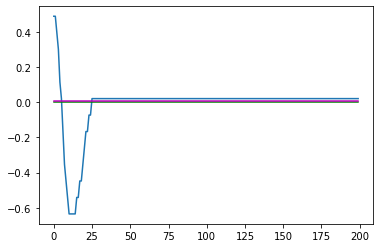

In [294]:
plt.plot(y_test_scaled[idx])
plt.plot(np.round(predictions[idx], 1), color = 'g')
plt.plot(predictions[idx], color = 'm')

In [277]:
calculate_single_mse(x_test_scaled[idx], predictions[idx])

[[182, 197]]


0.3158004435172866

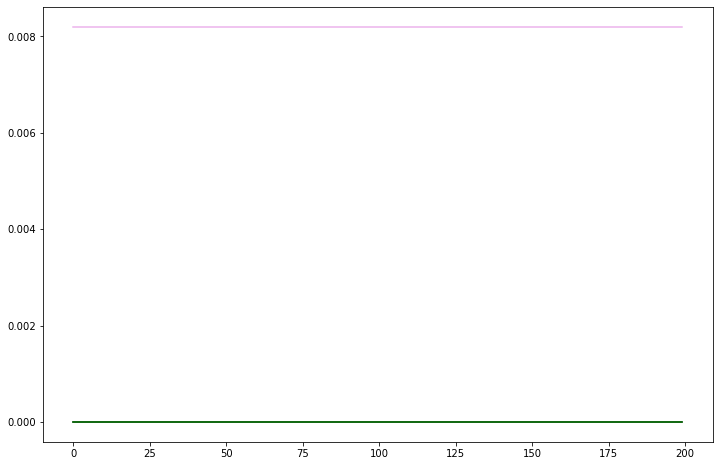

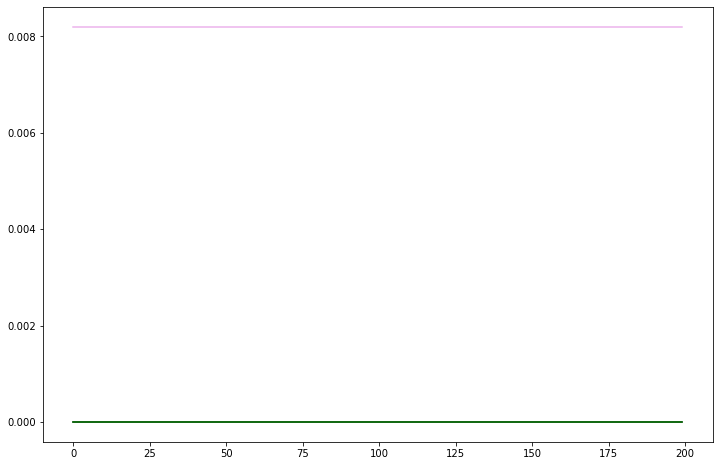

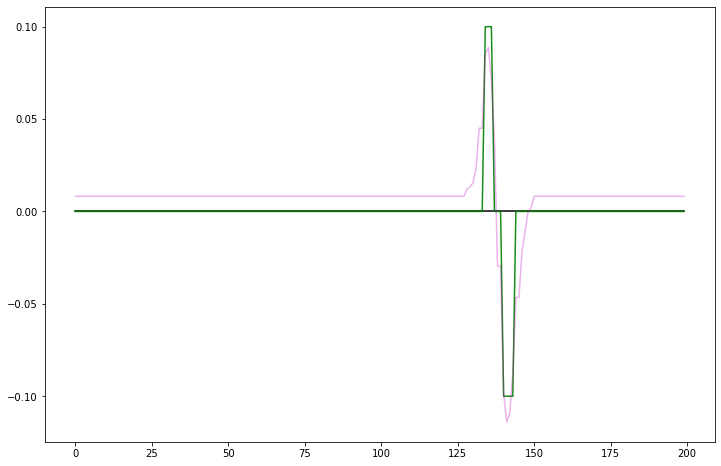

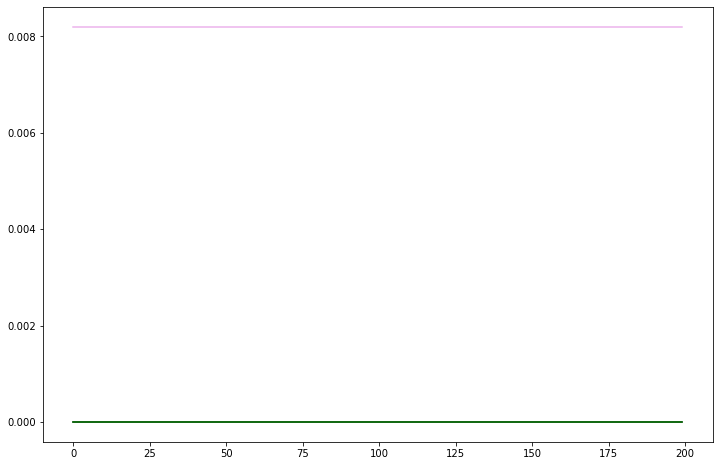

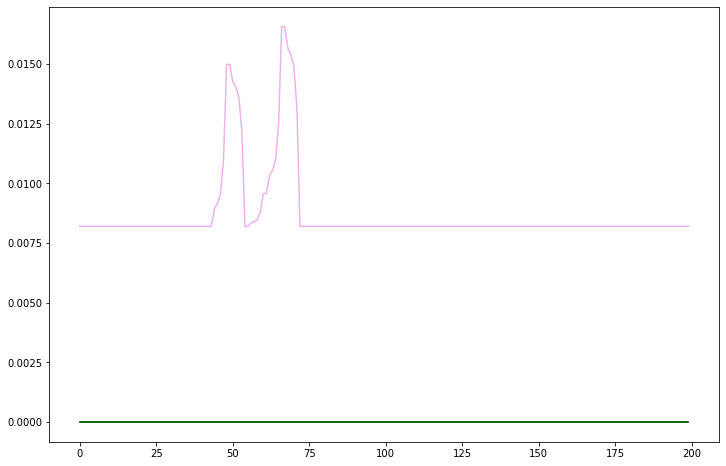

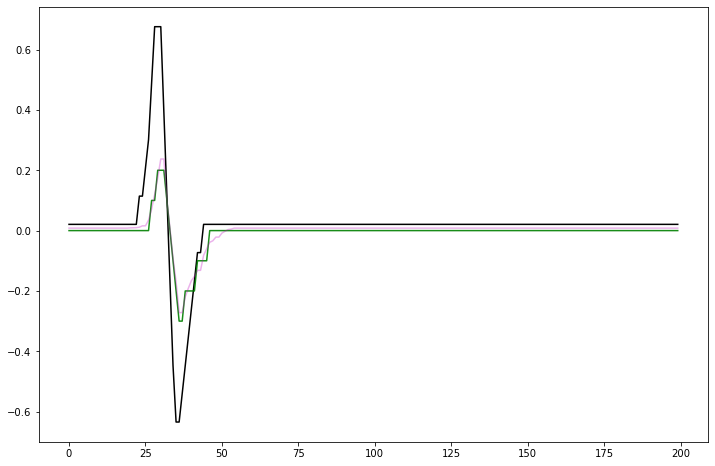

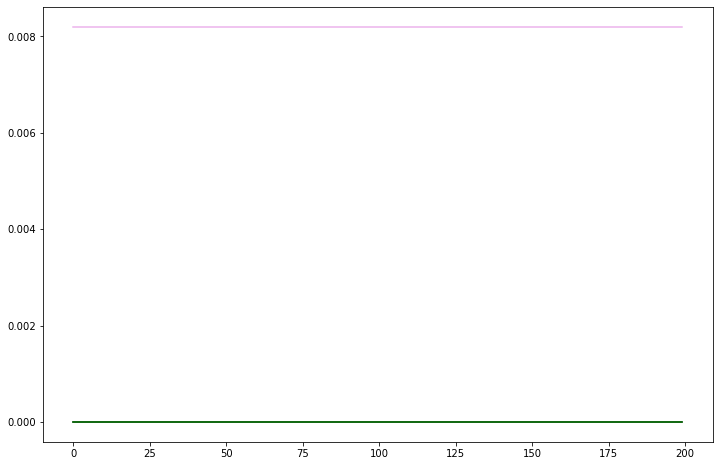

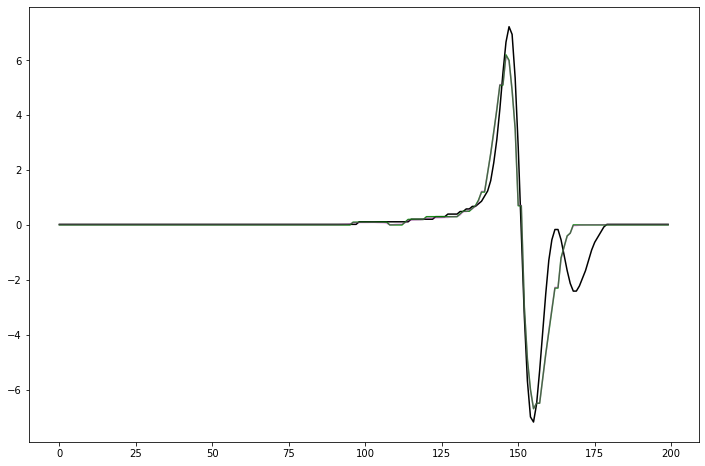

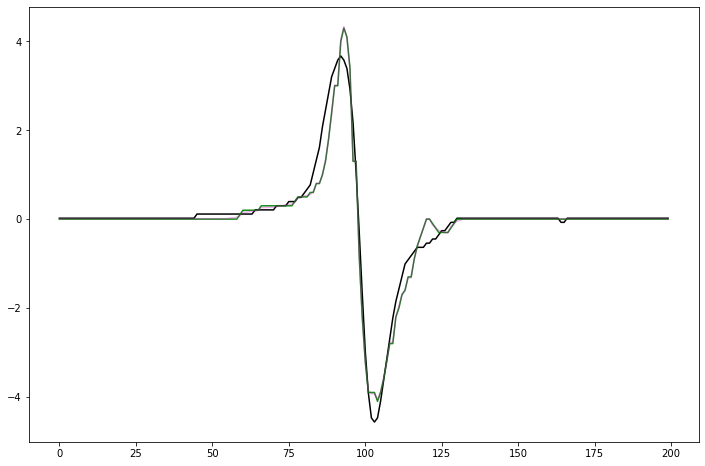

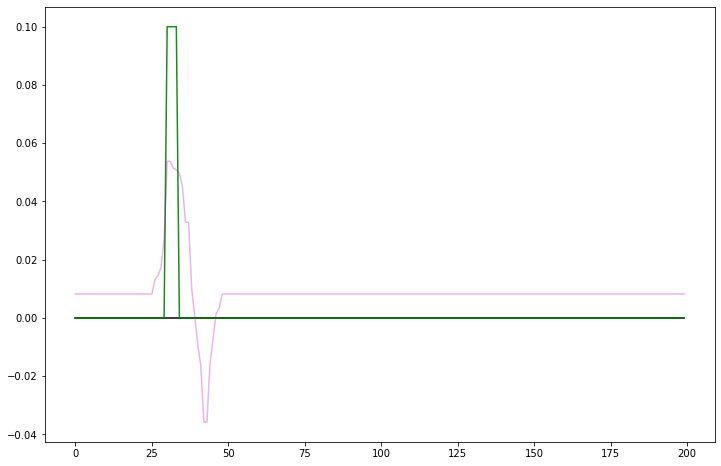

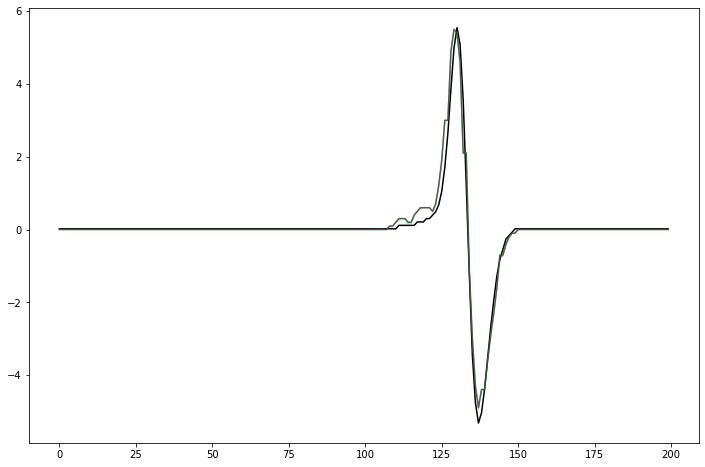

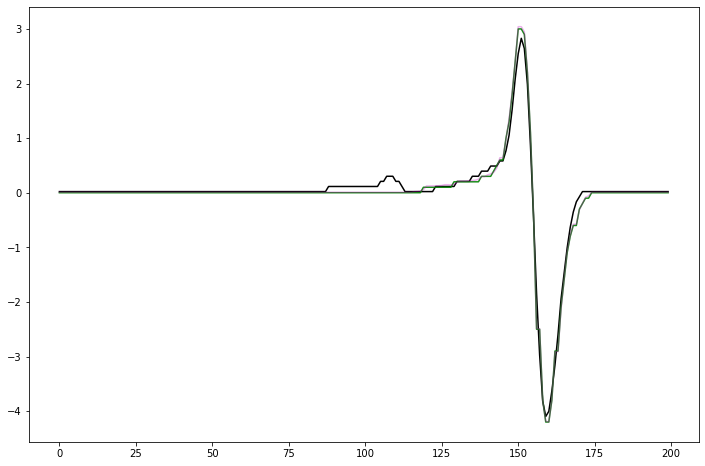

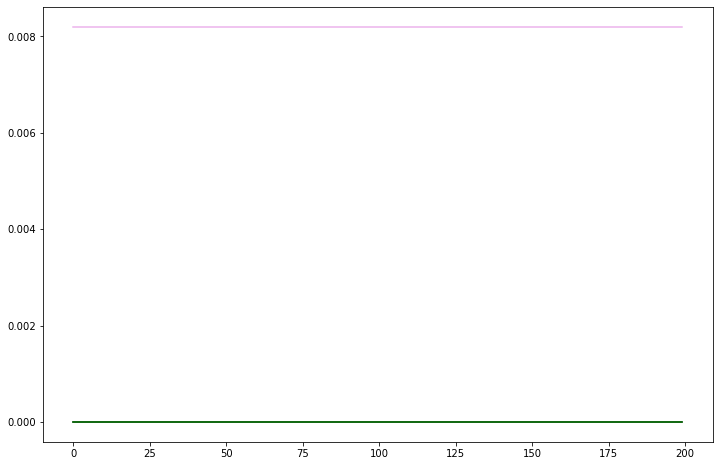

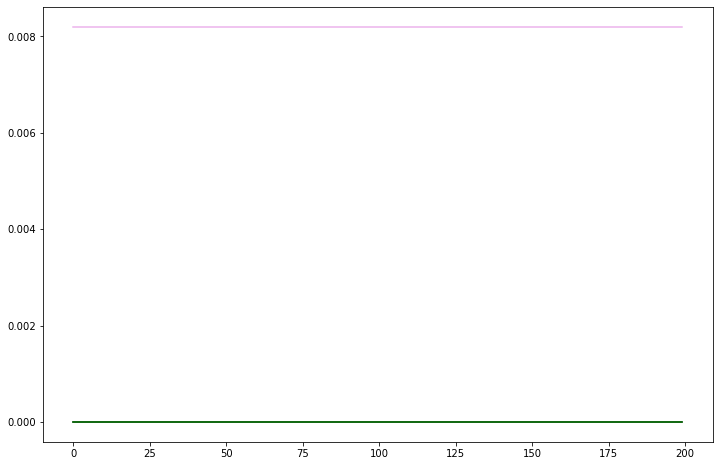

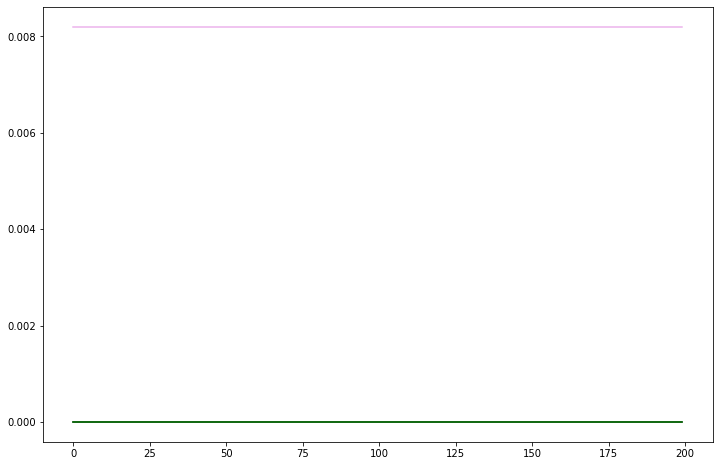

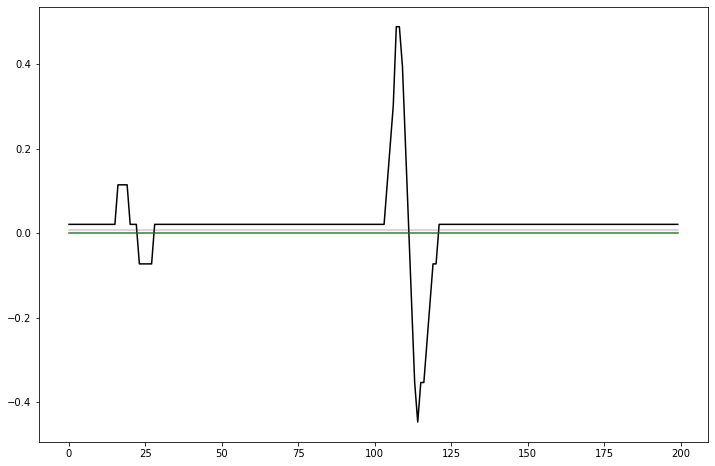

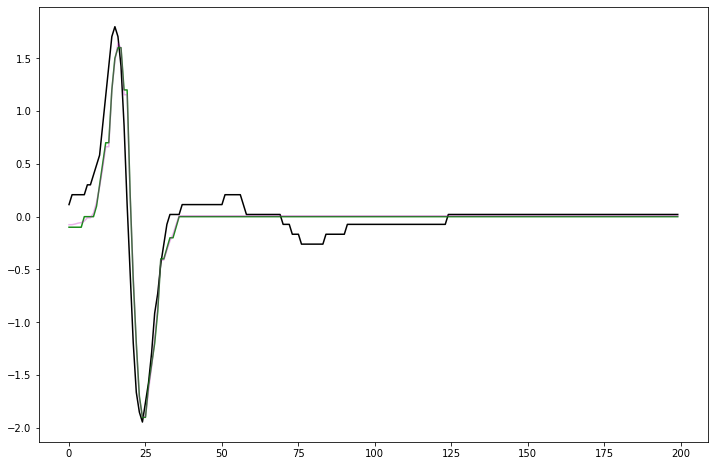

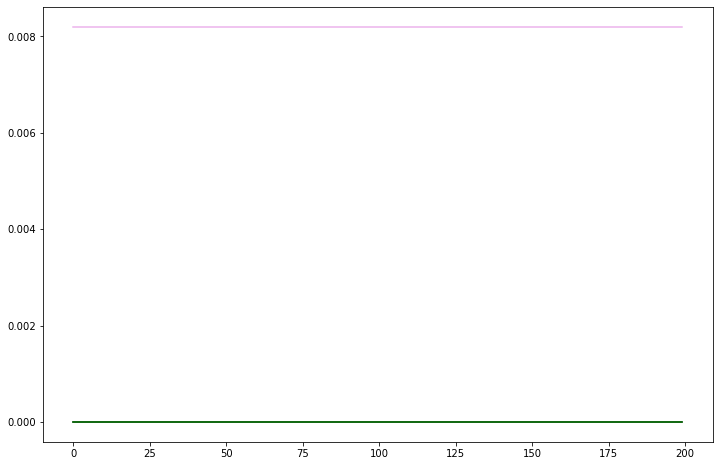

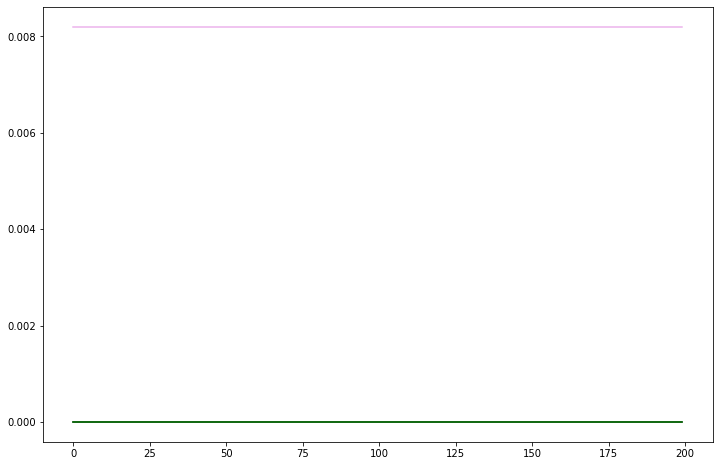

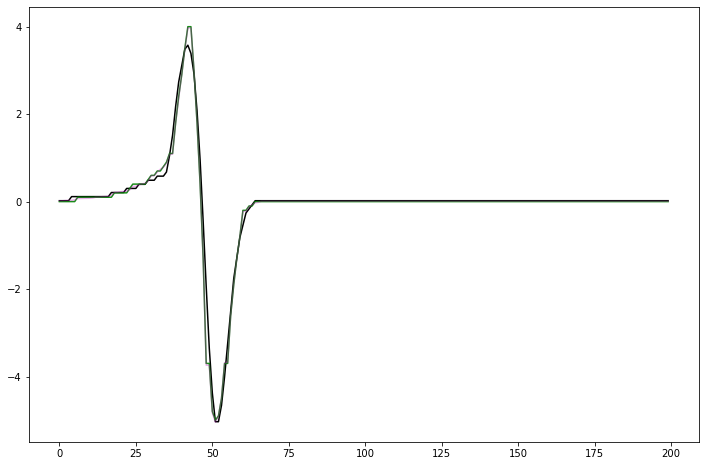

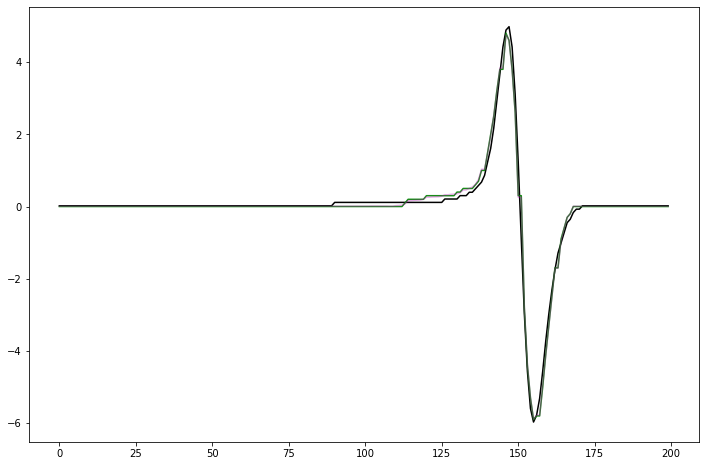

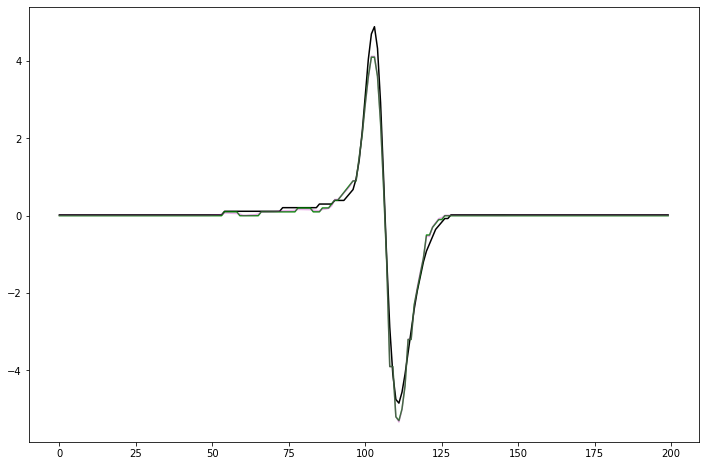

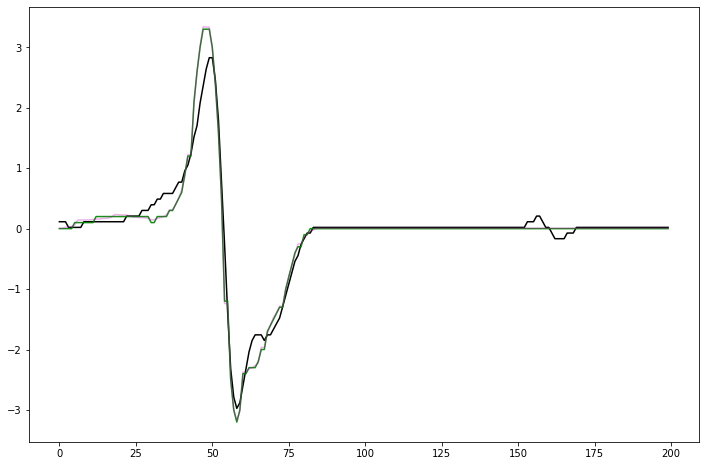

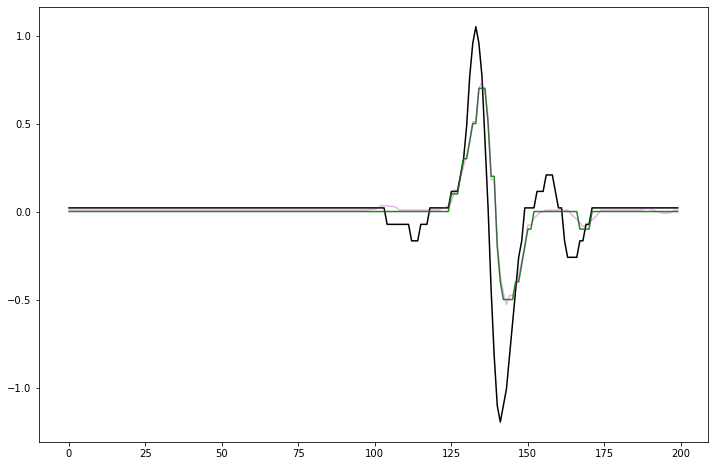

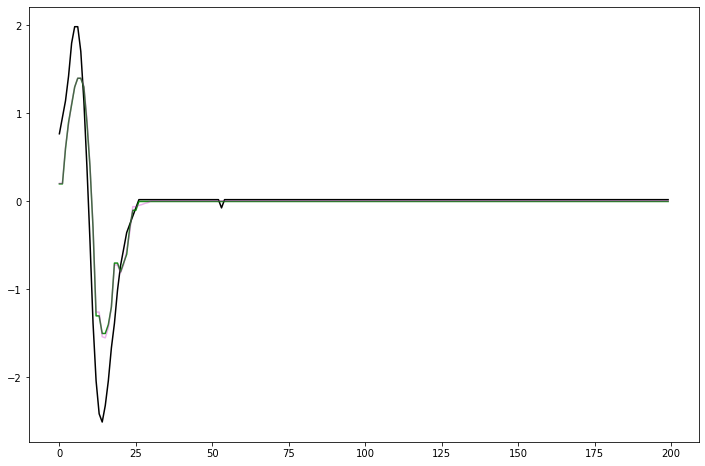

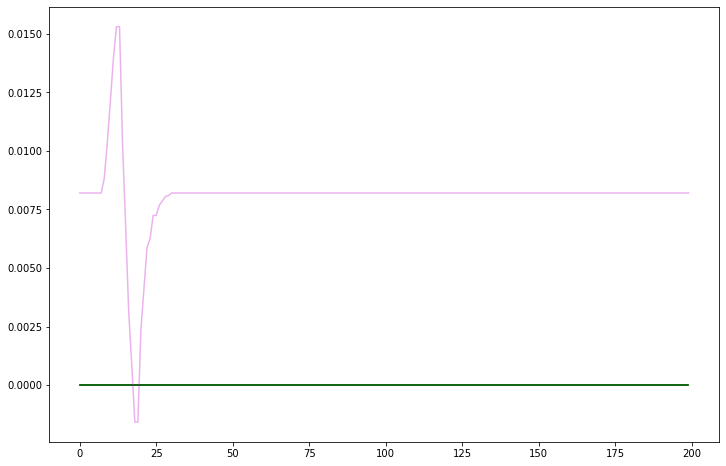

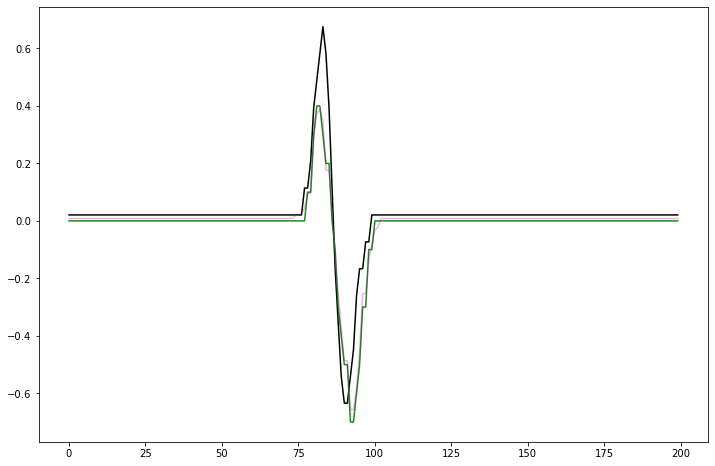

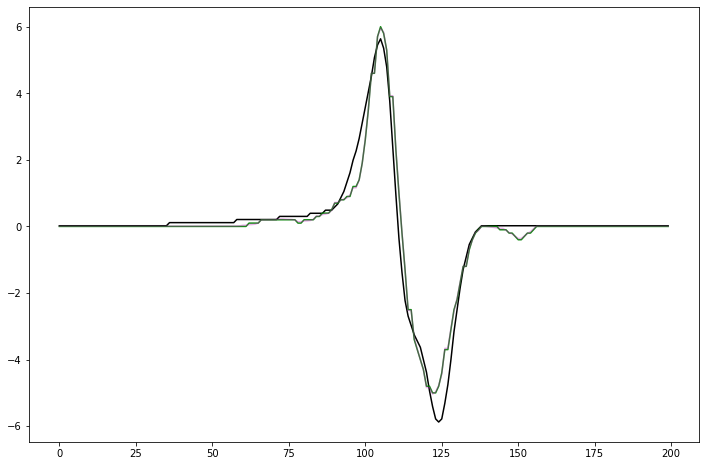

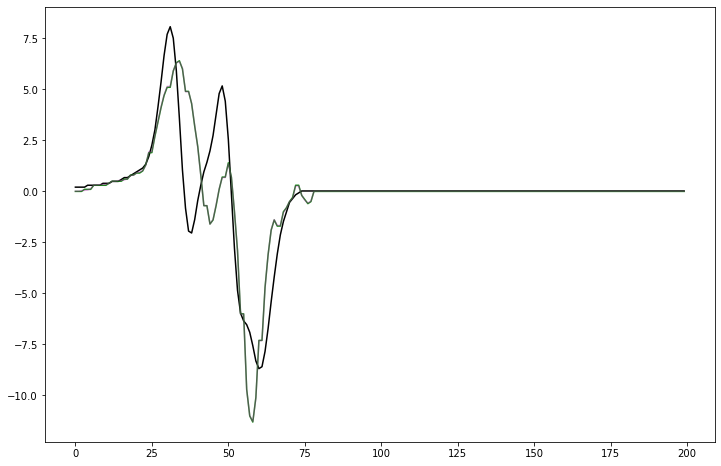

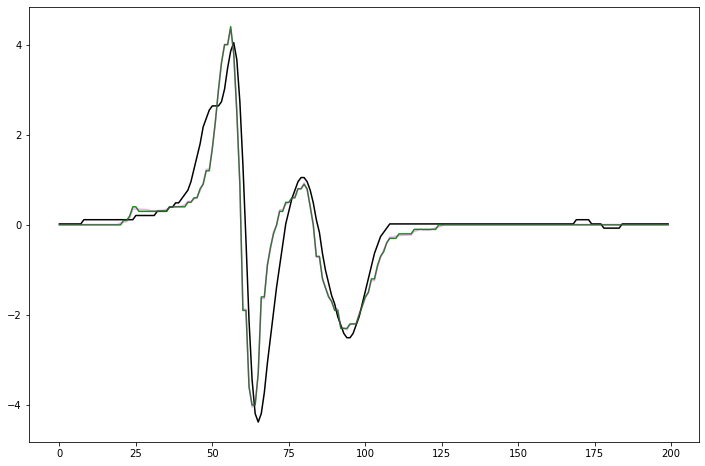

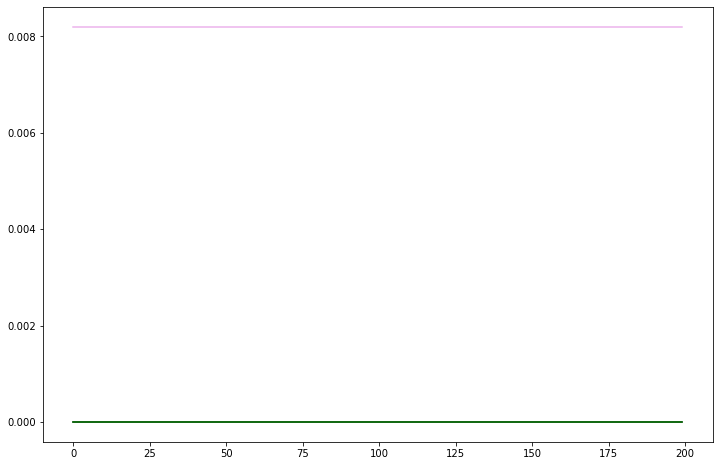

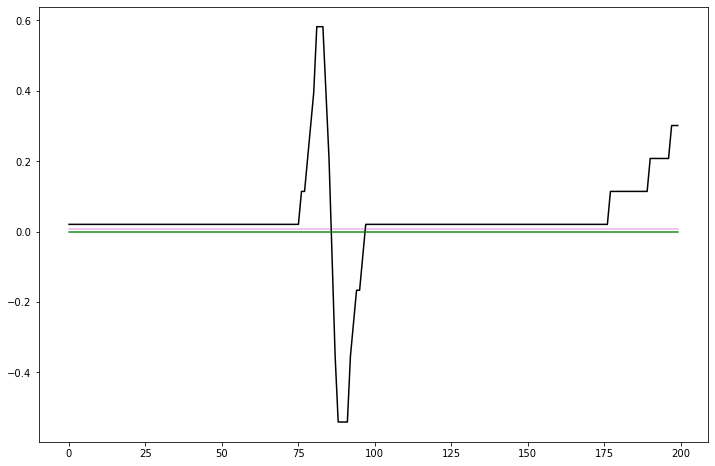

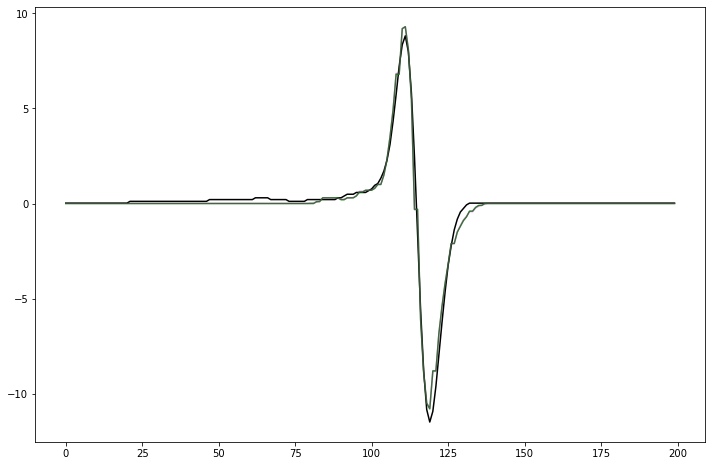

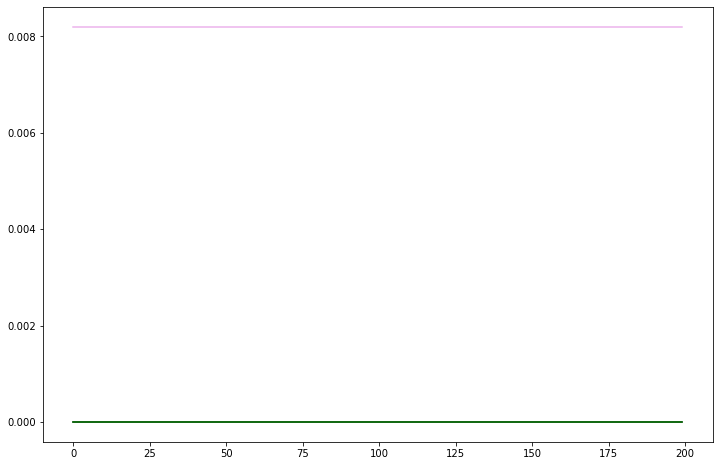

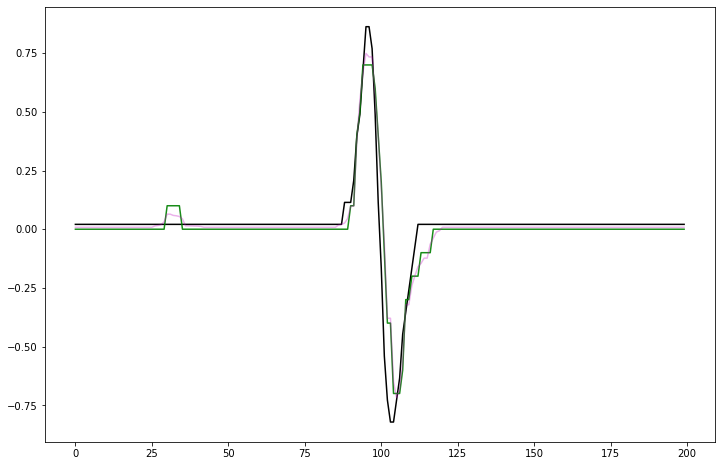

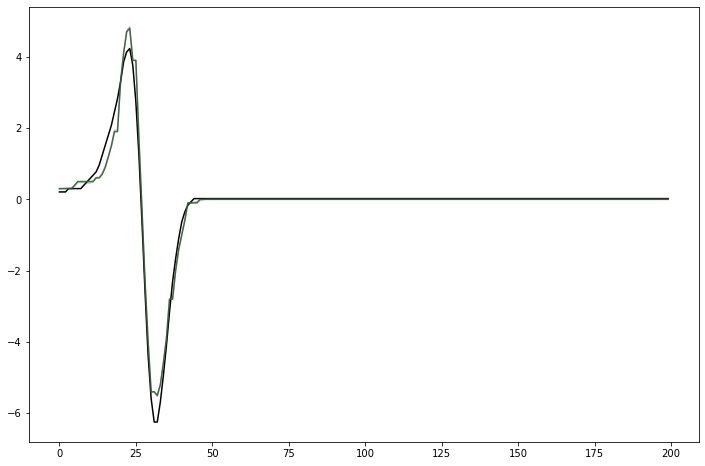

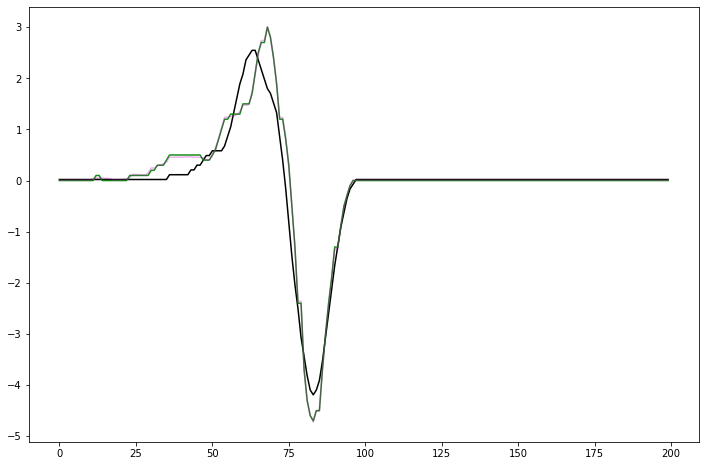

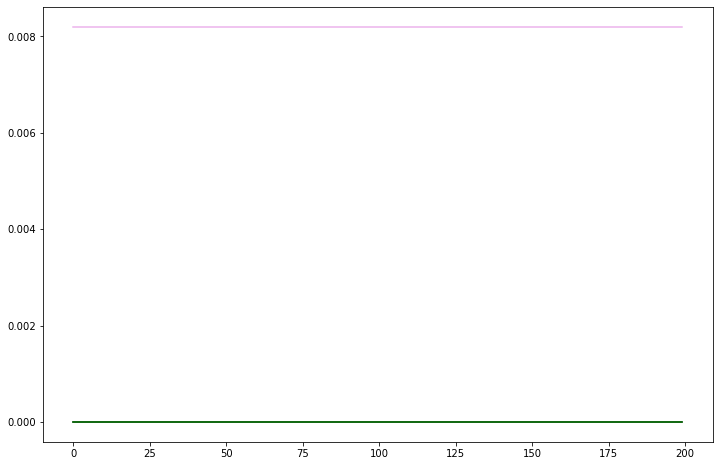

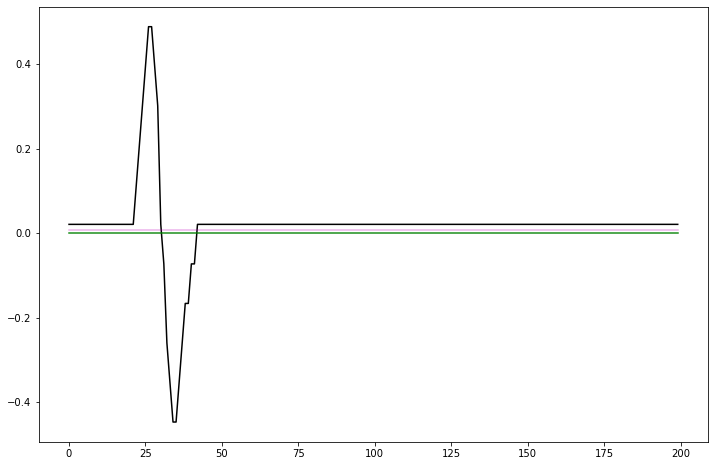

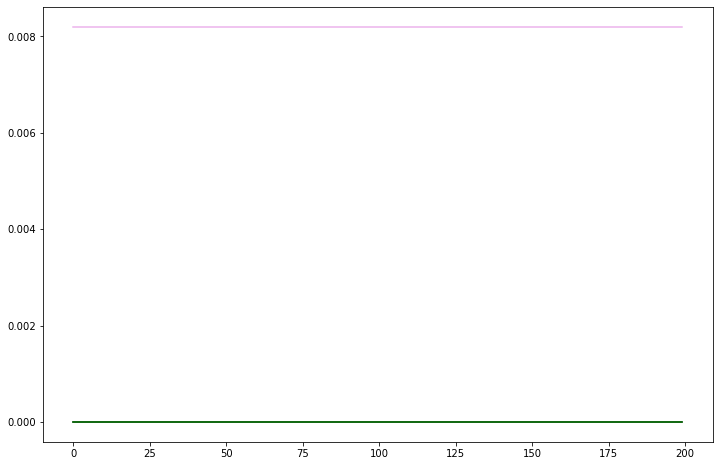

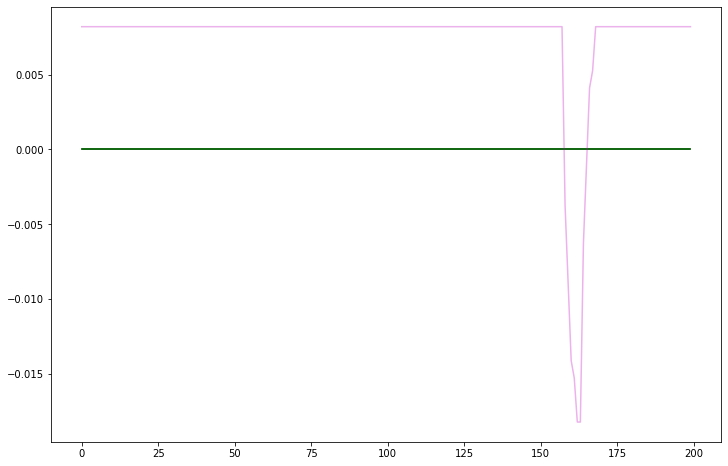

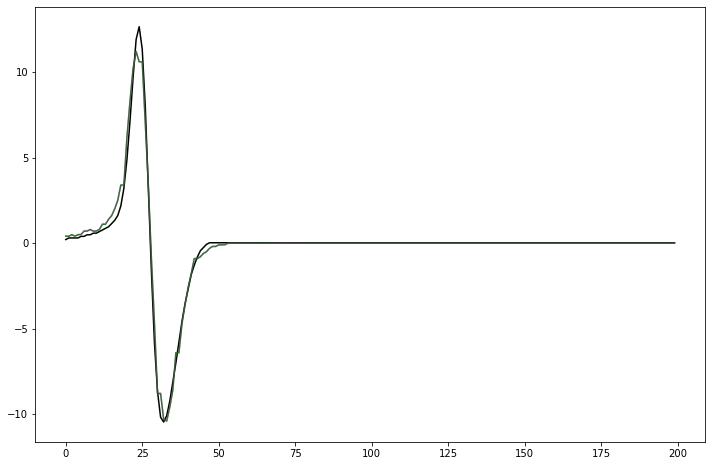

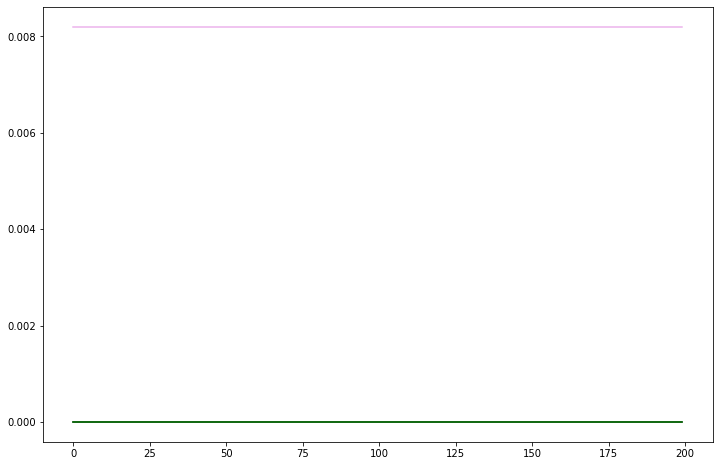

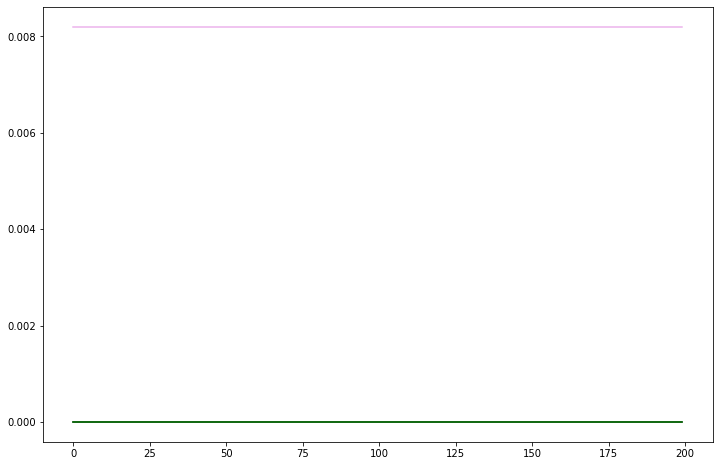

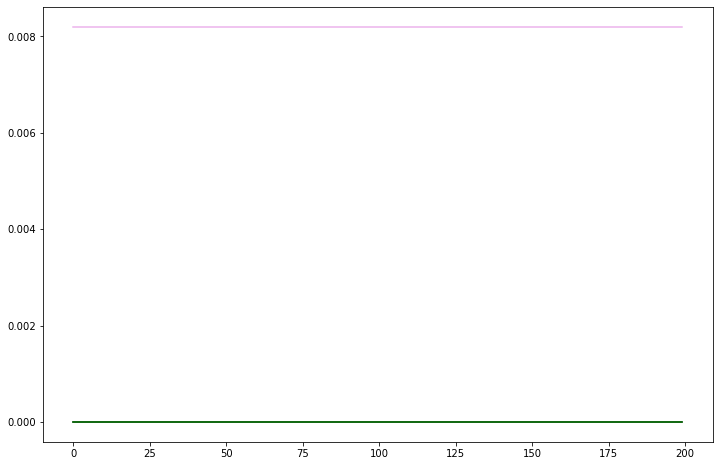

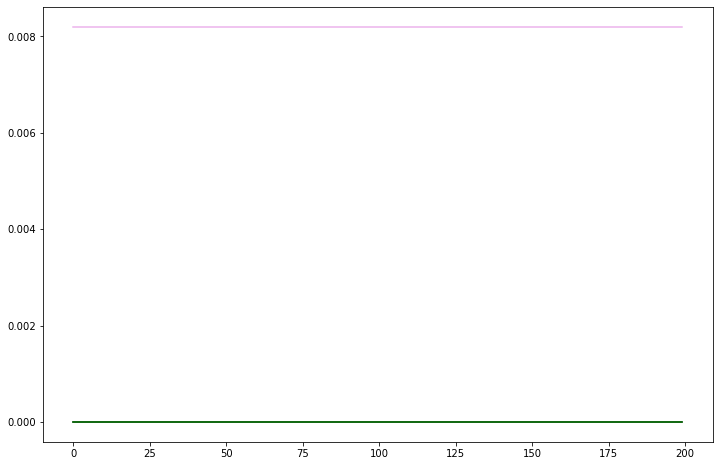

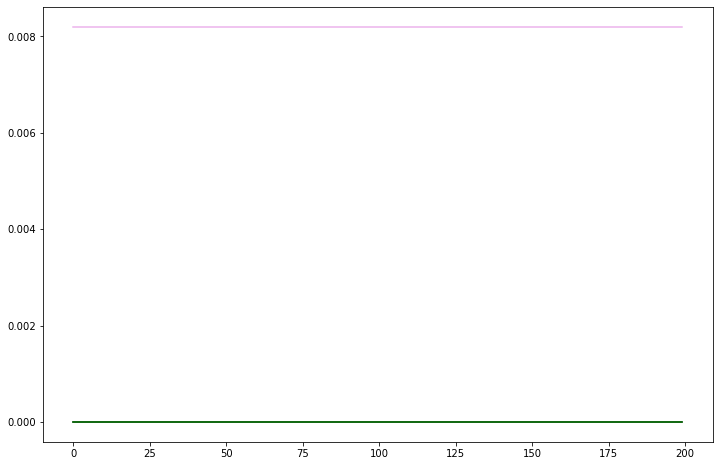

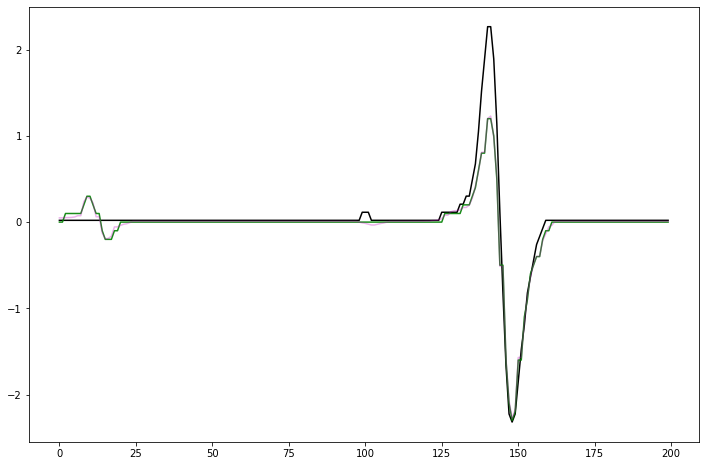

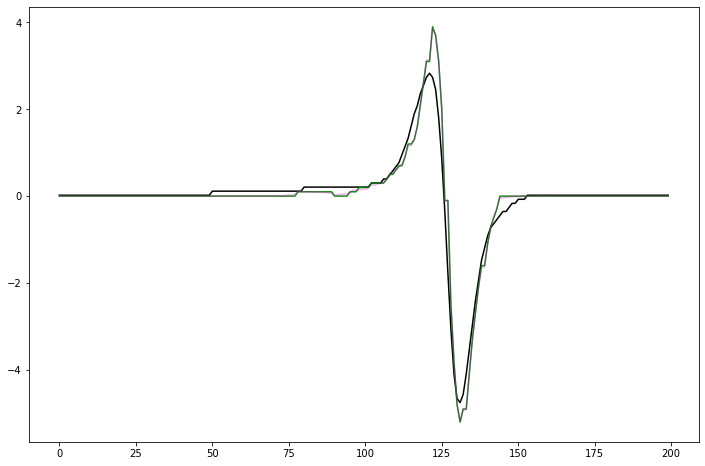

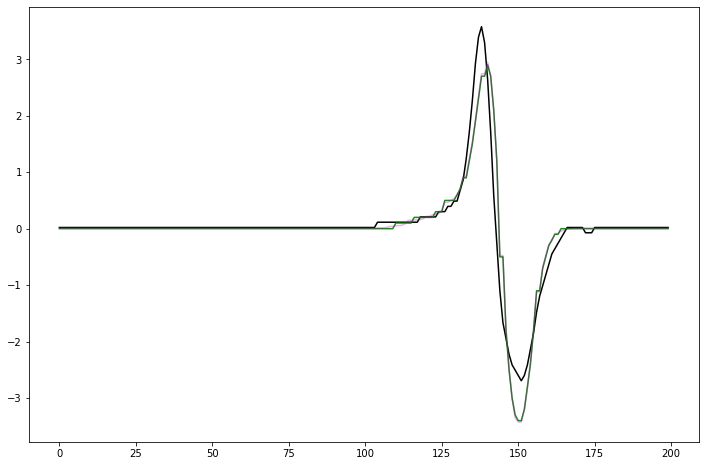

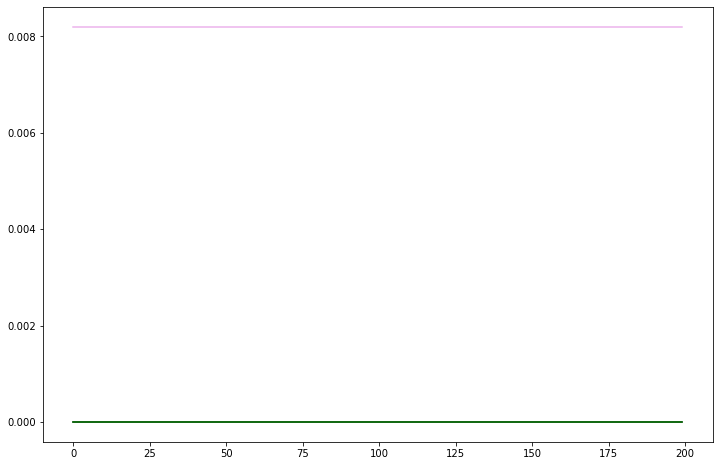

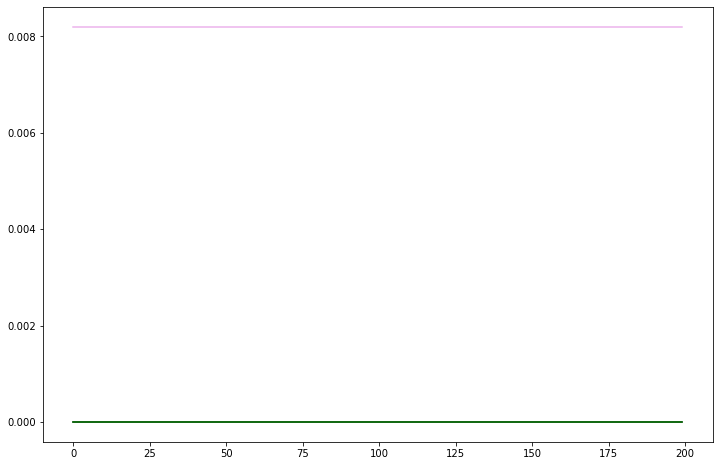

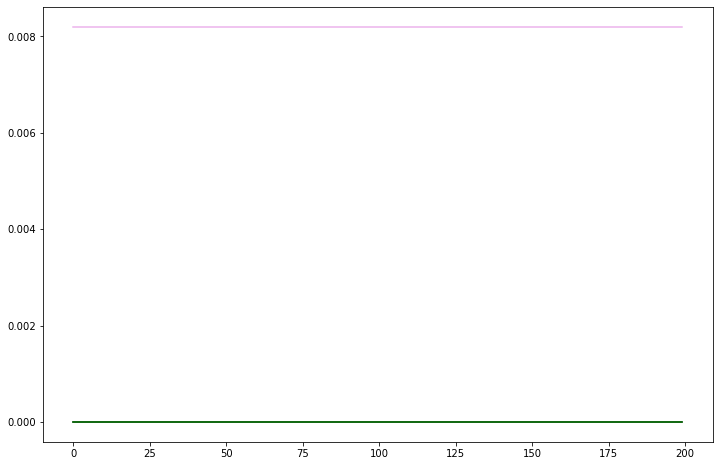

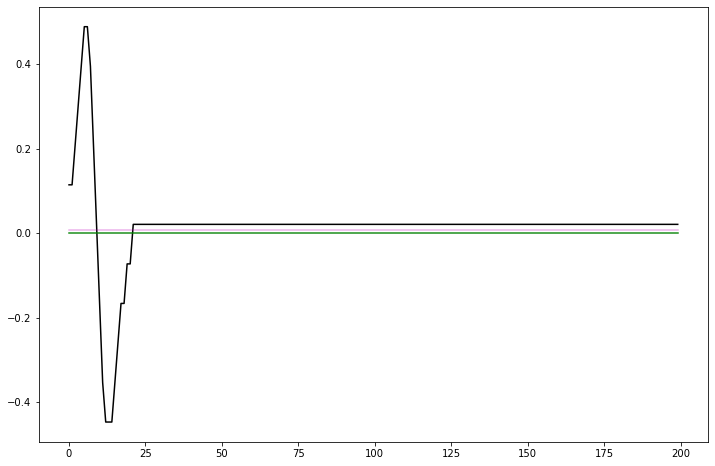

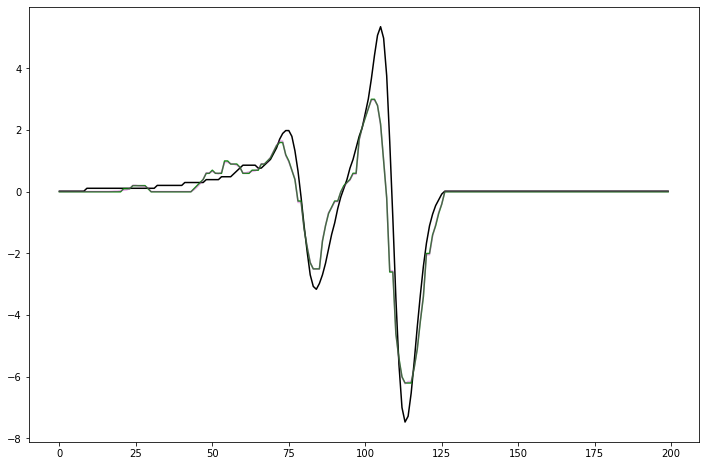

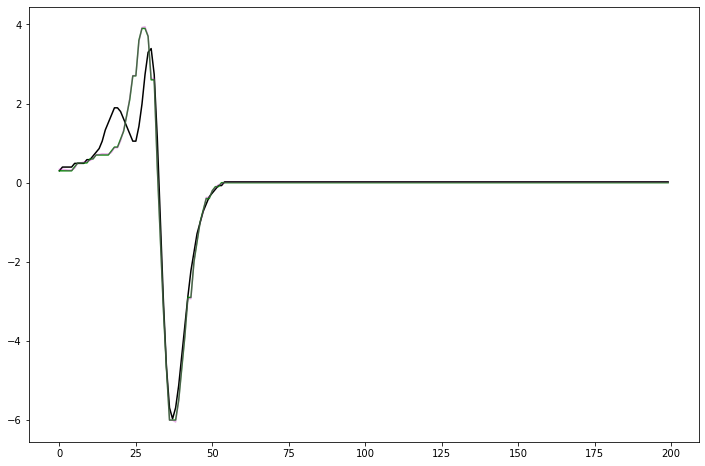

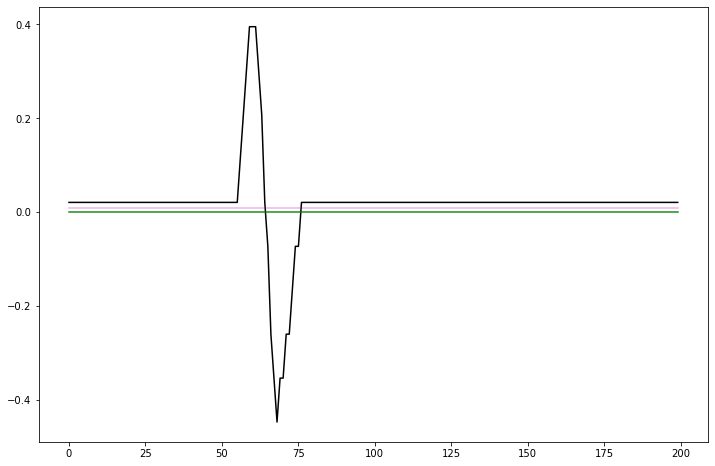

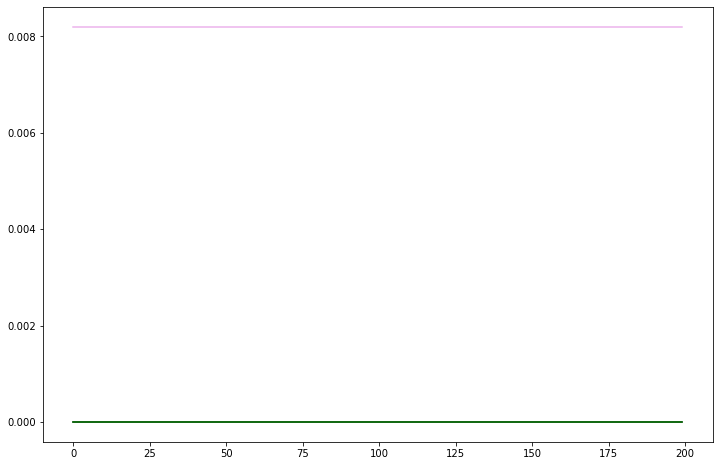

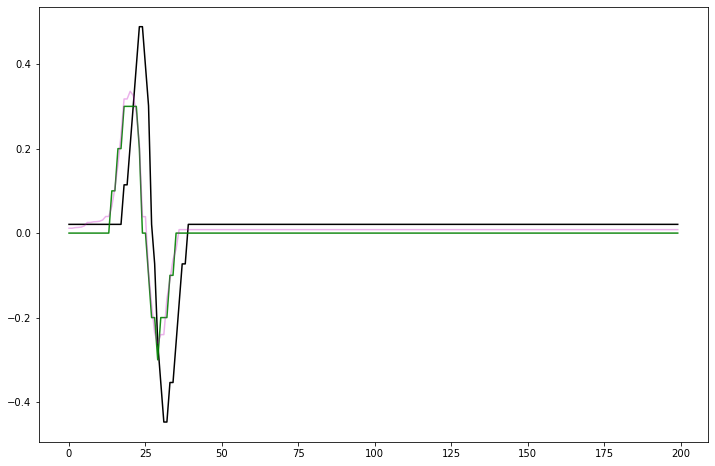

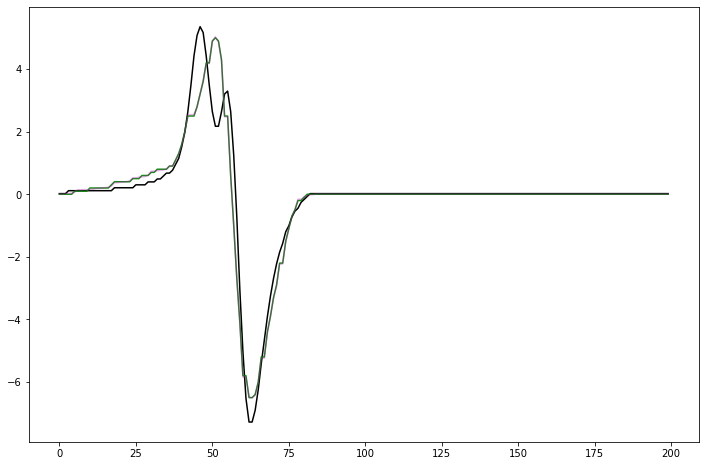

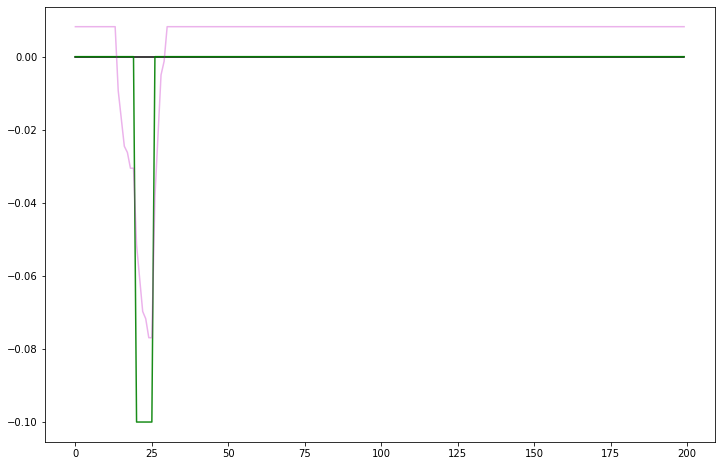

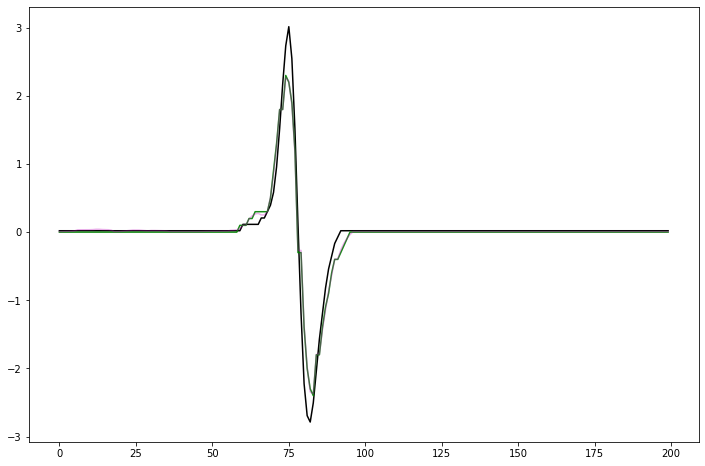

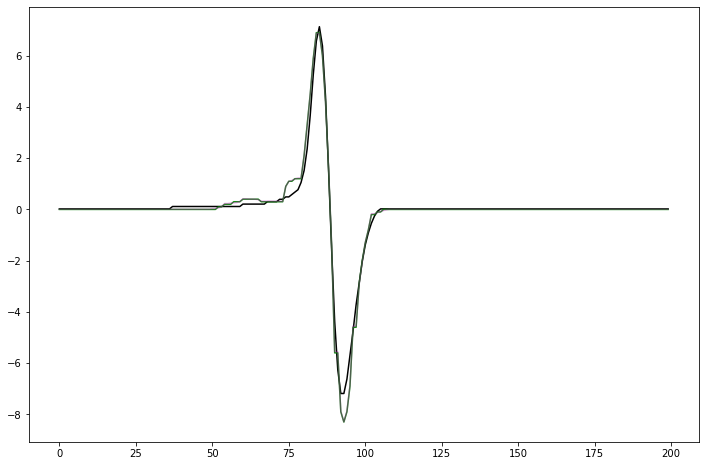

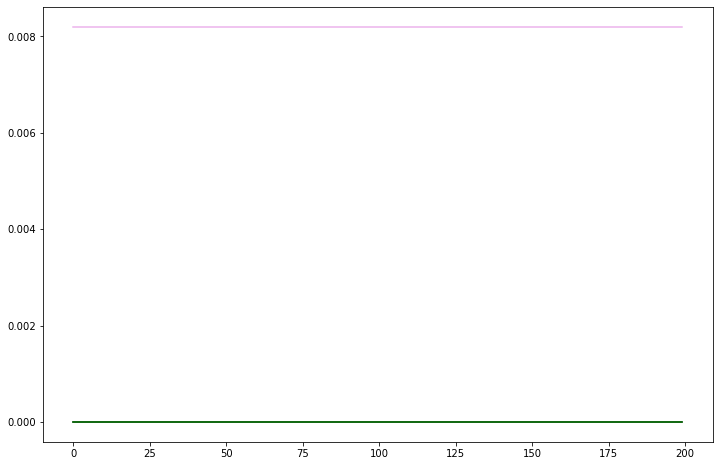

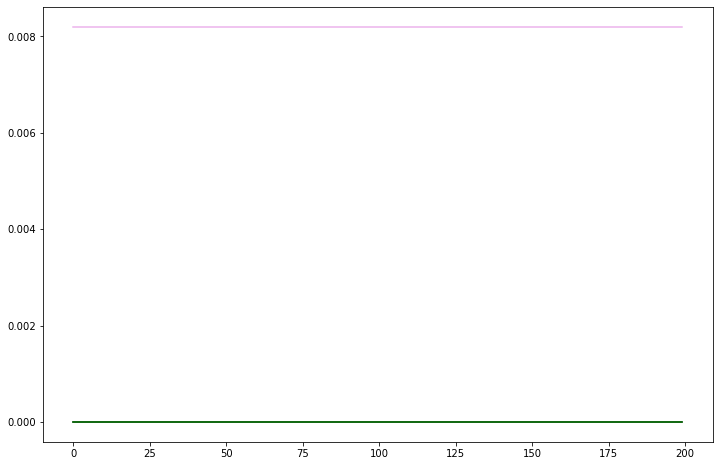

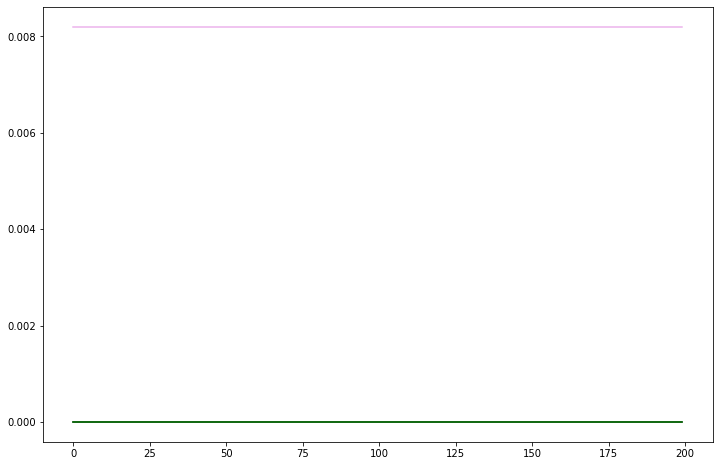

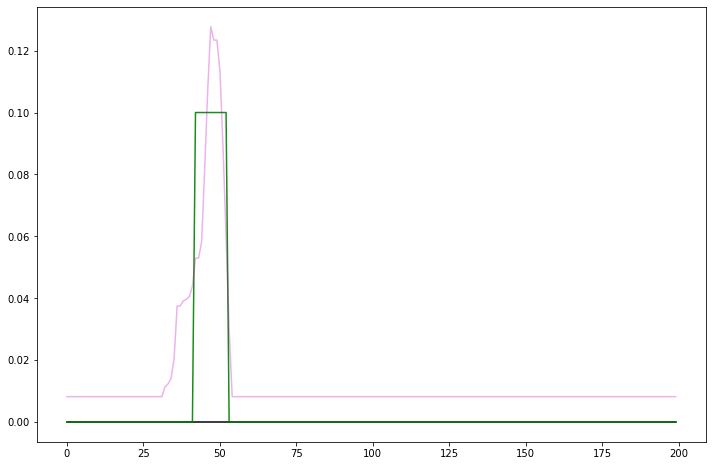

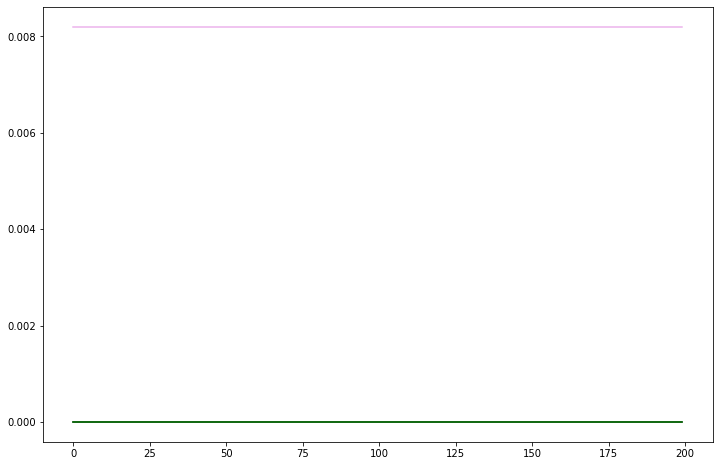

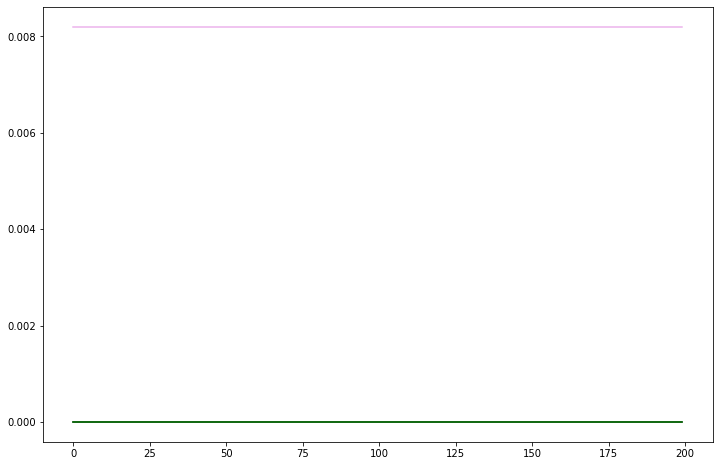

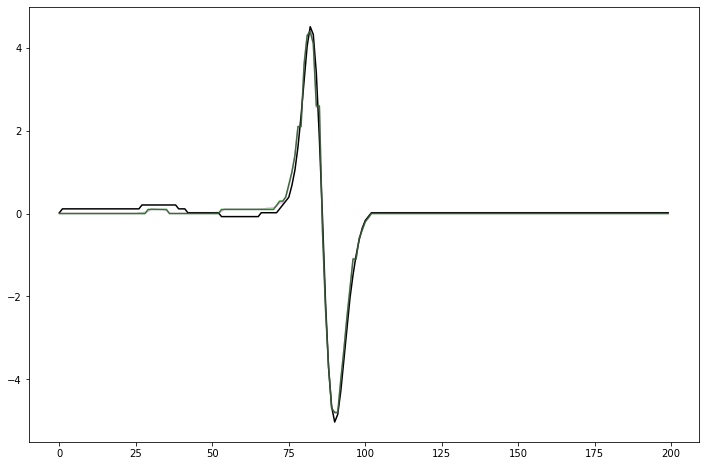

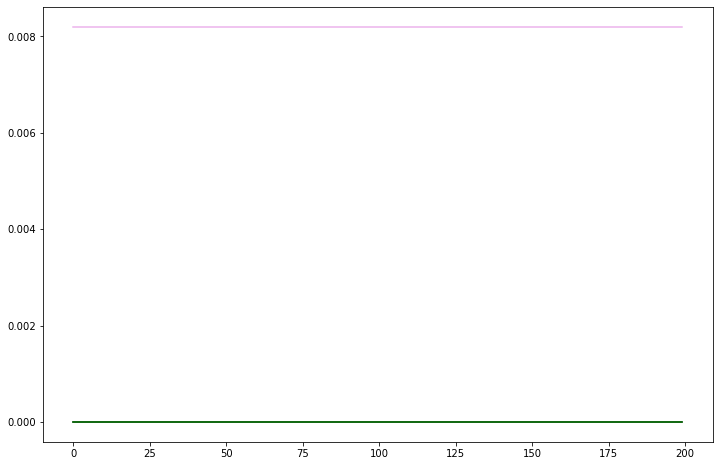

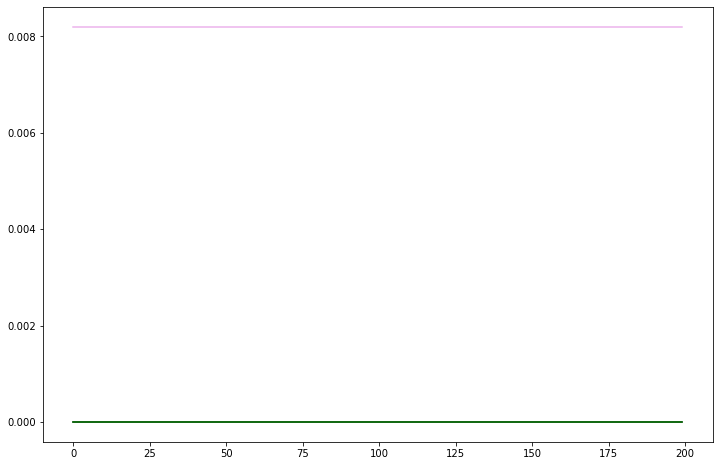

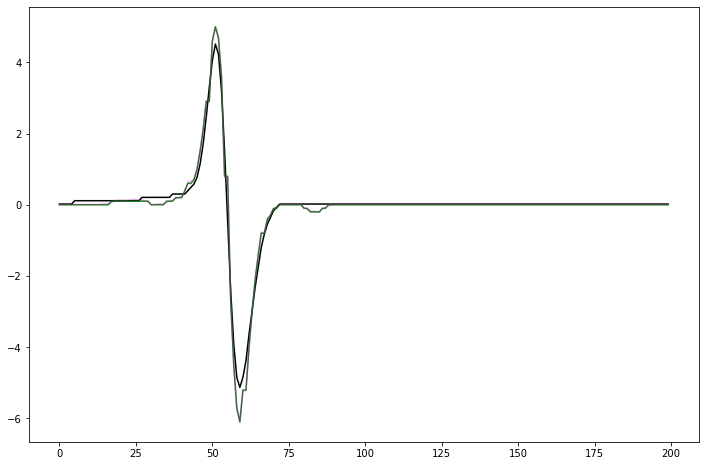

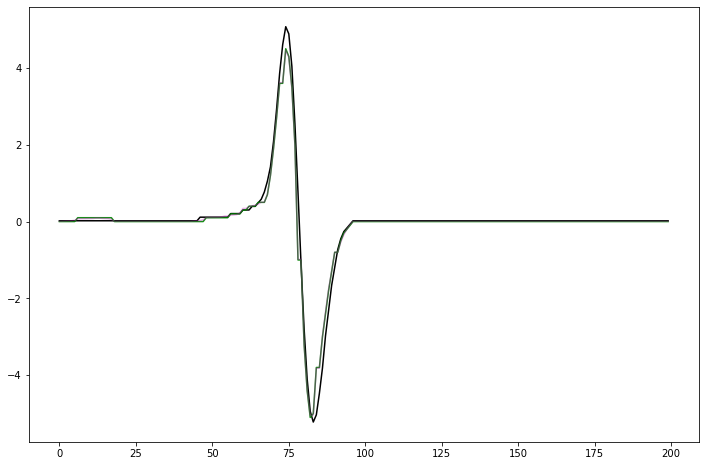

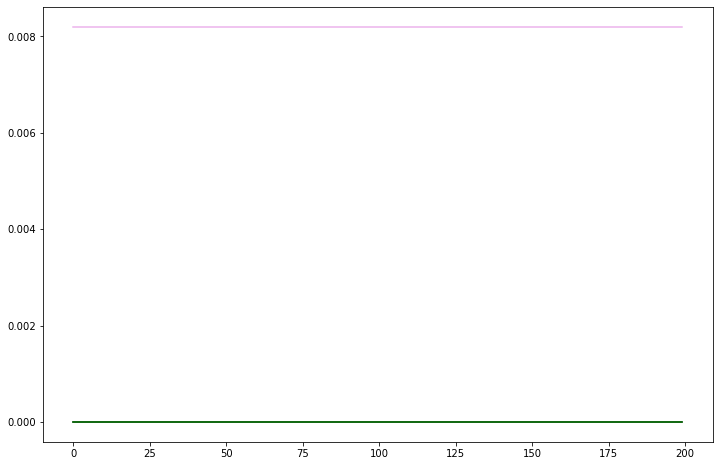

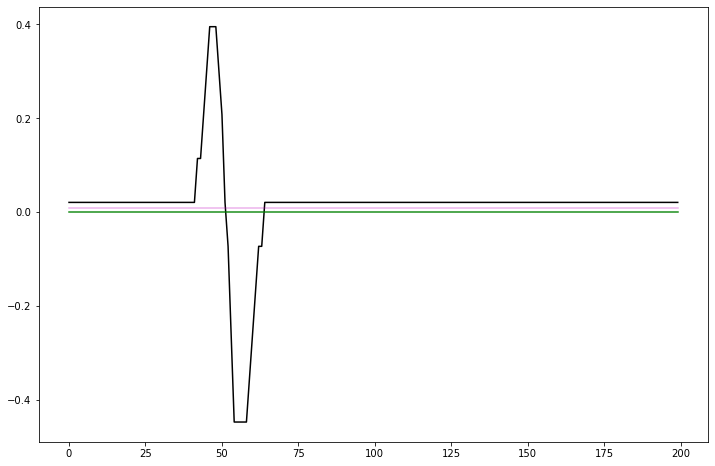

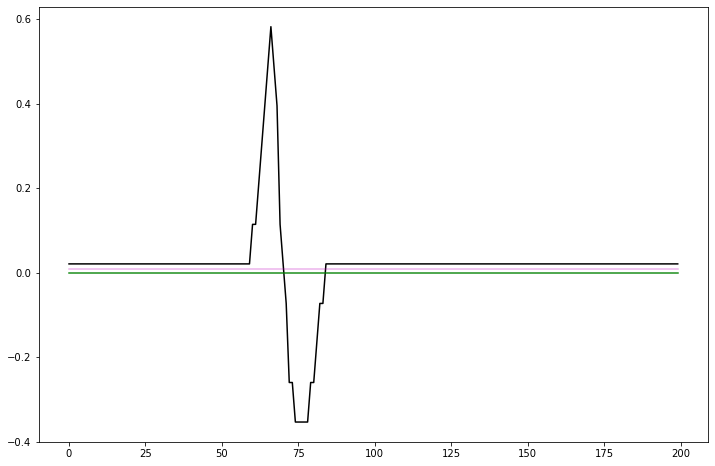

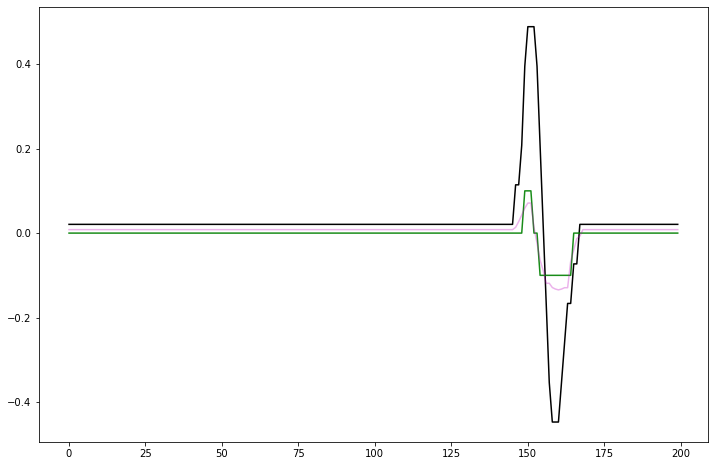

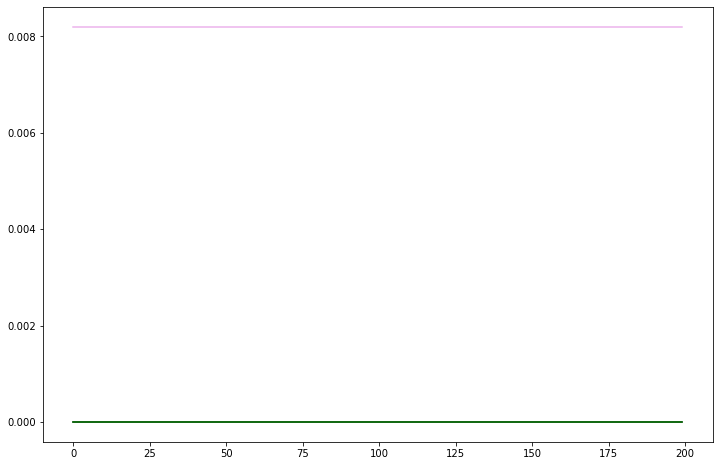

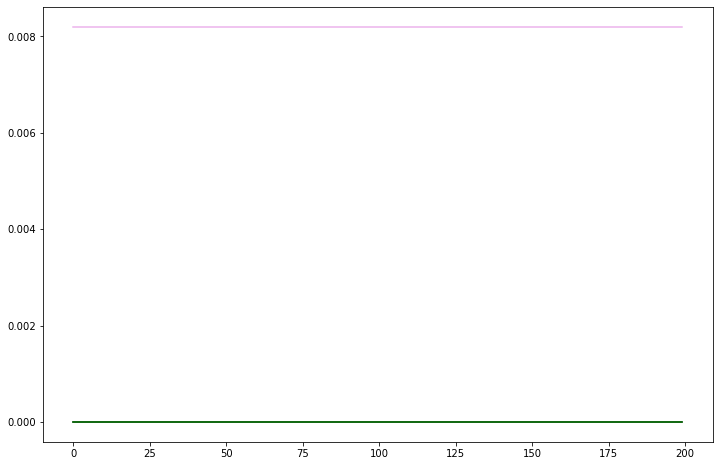

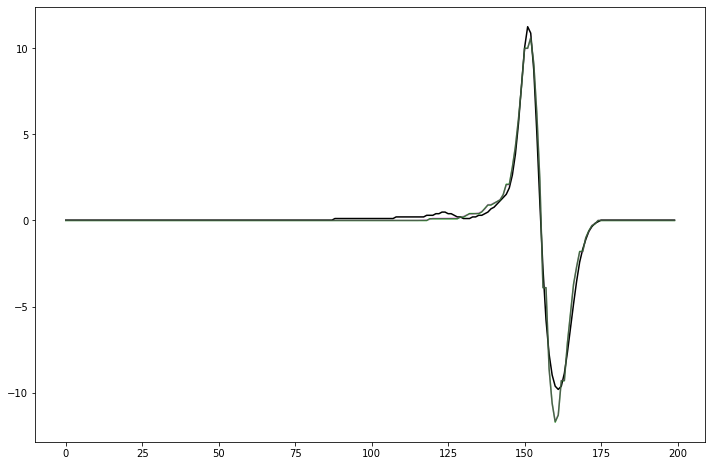

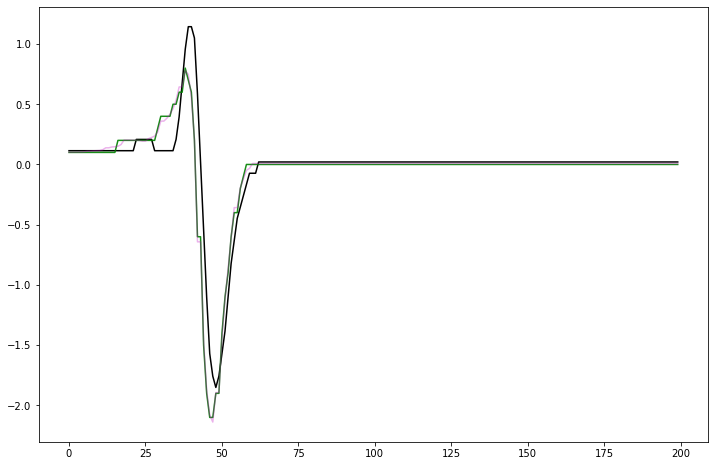

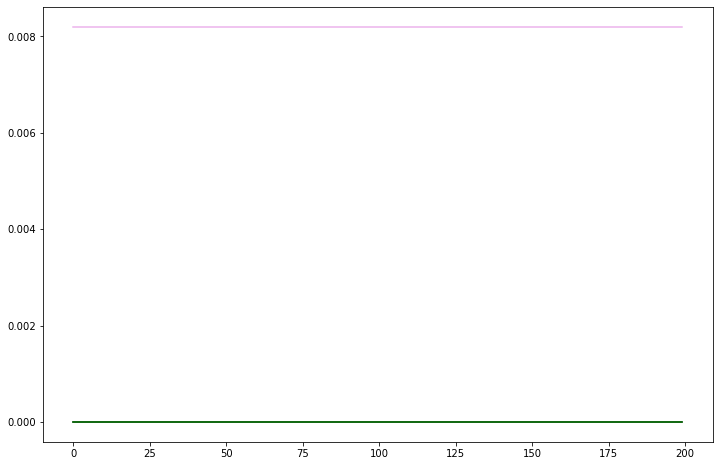

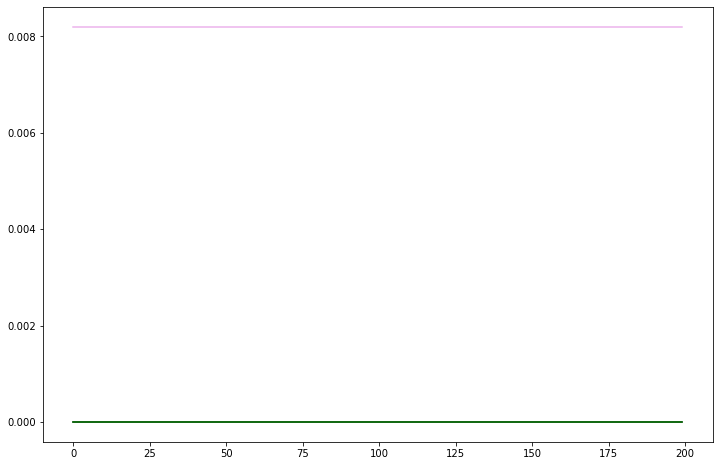

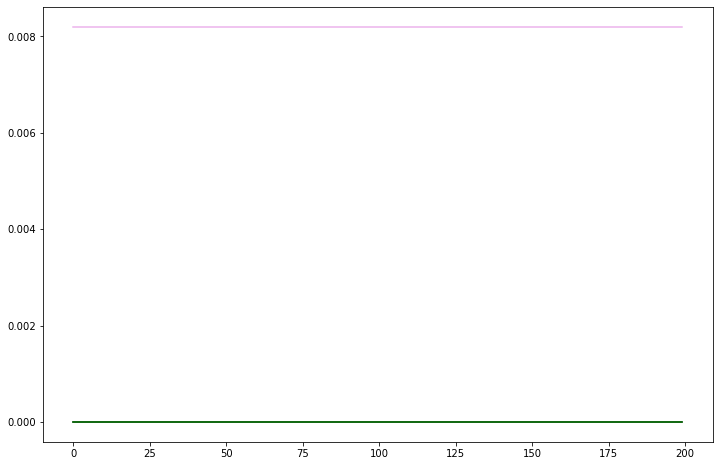

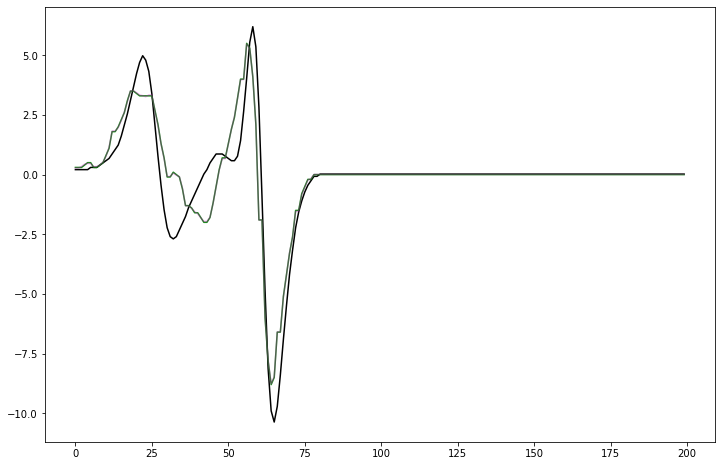

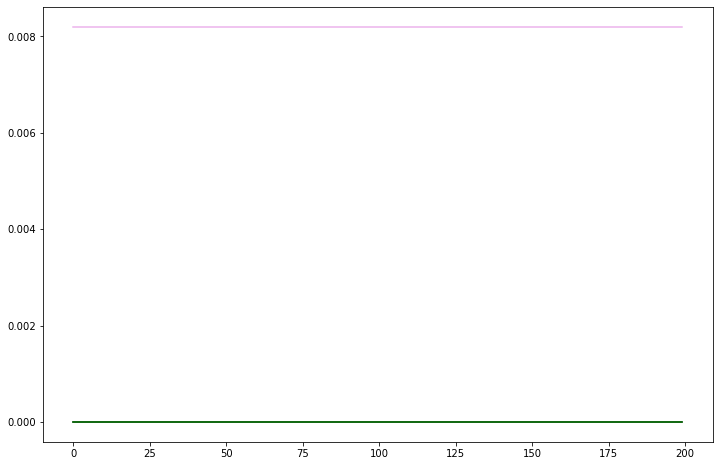

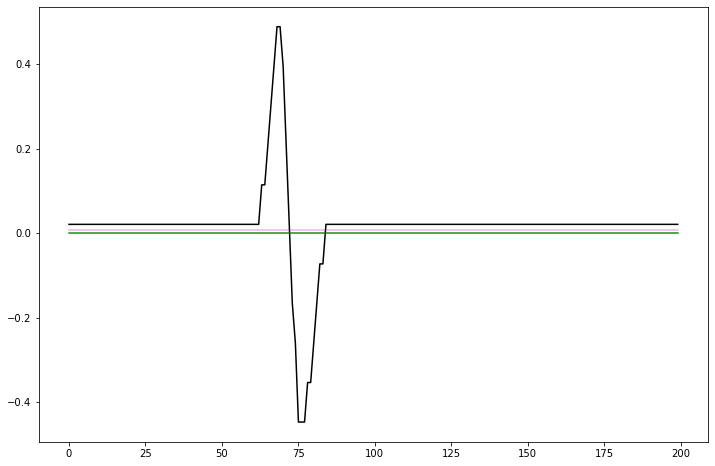

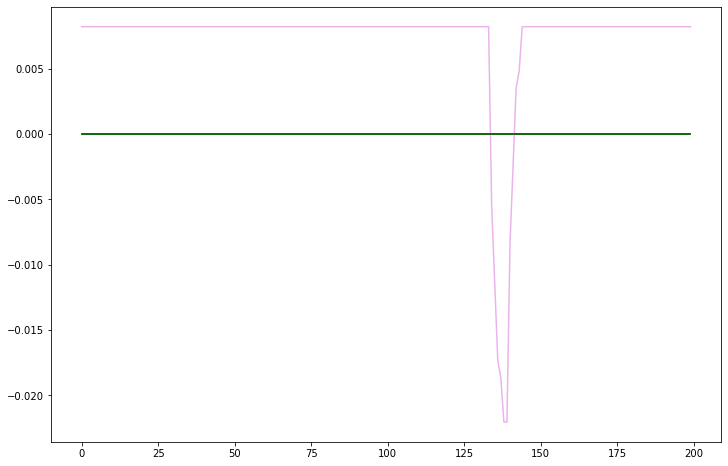

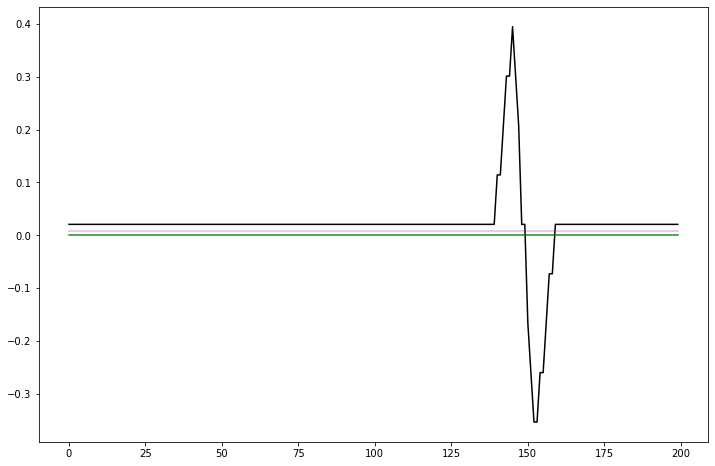

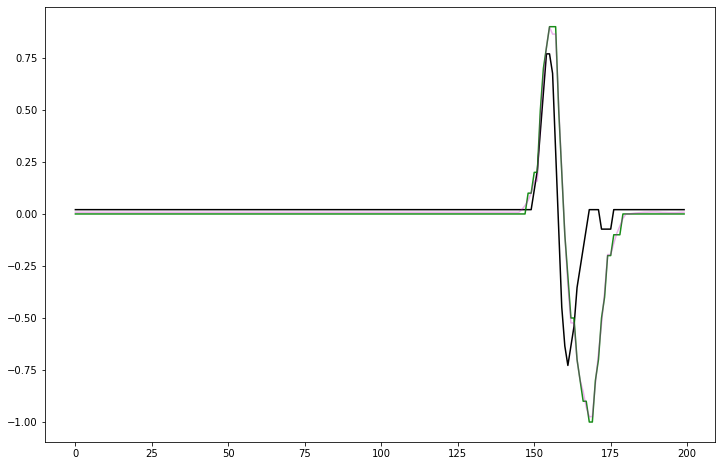

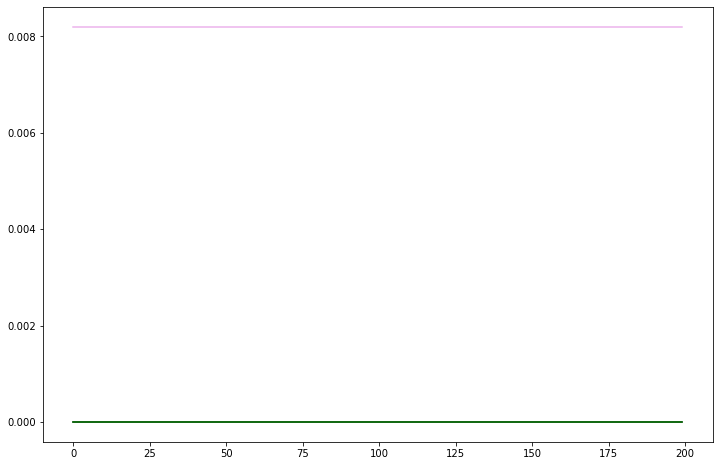

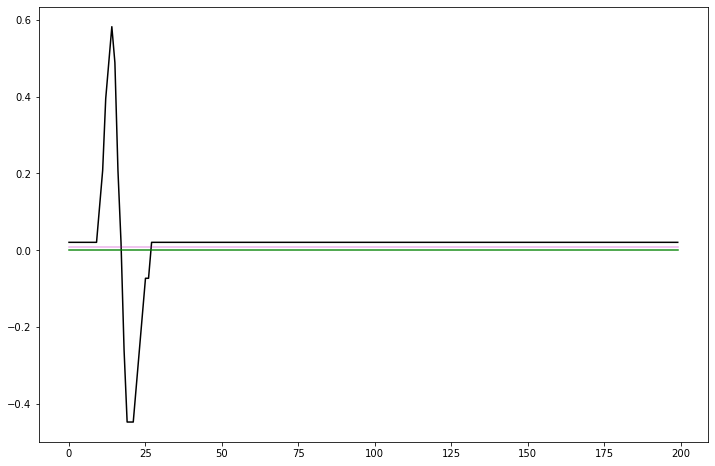

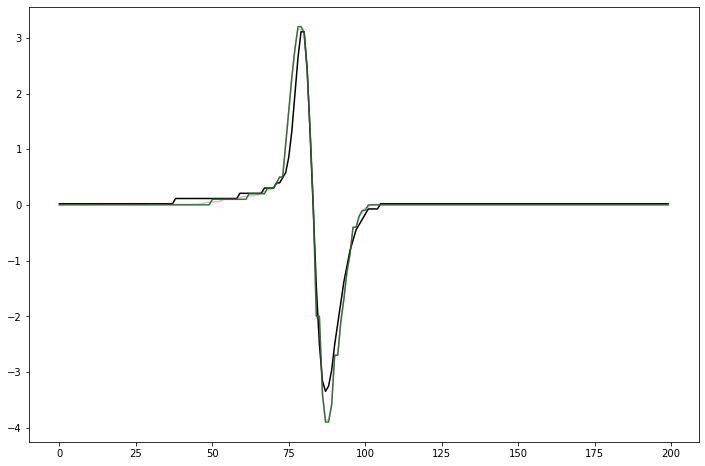

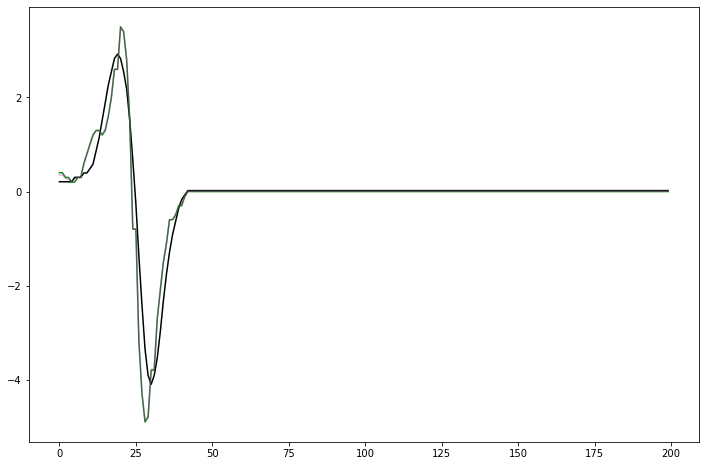

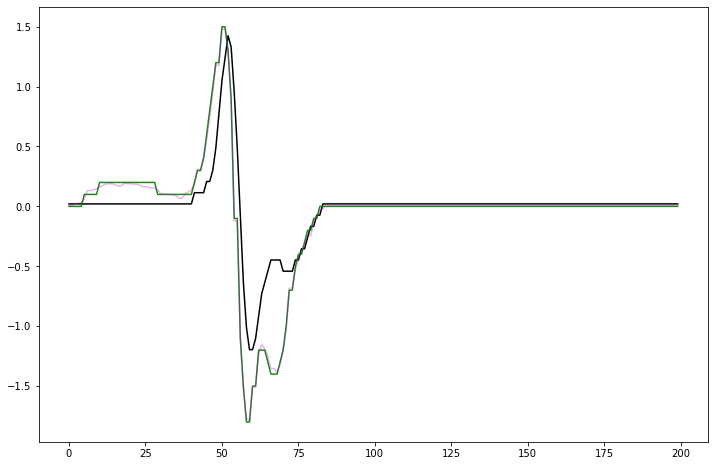

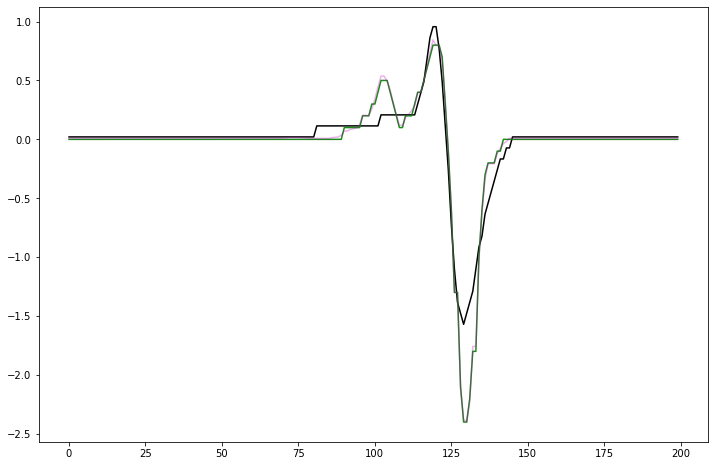

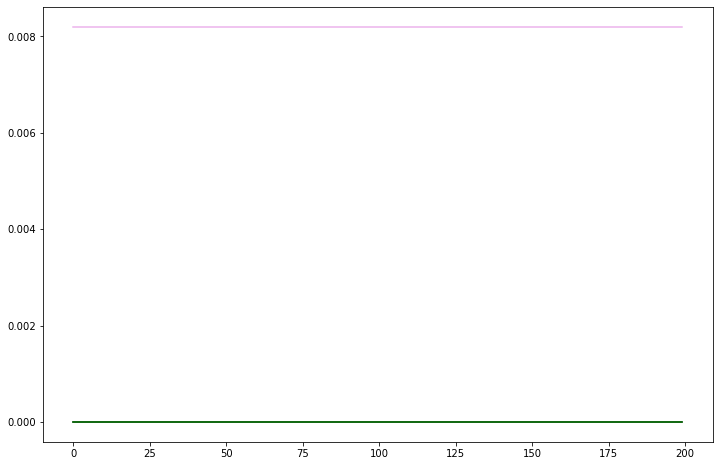

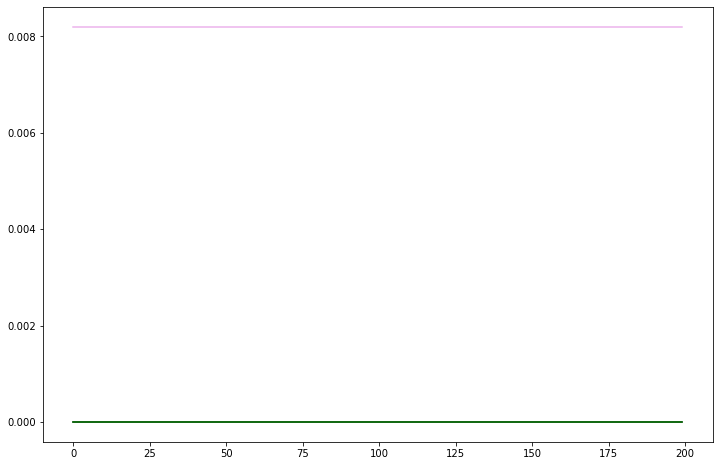

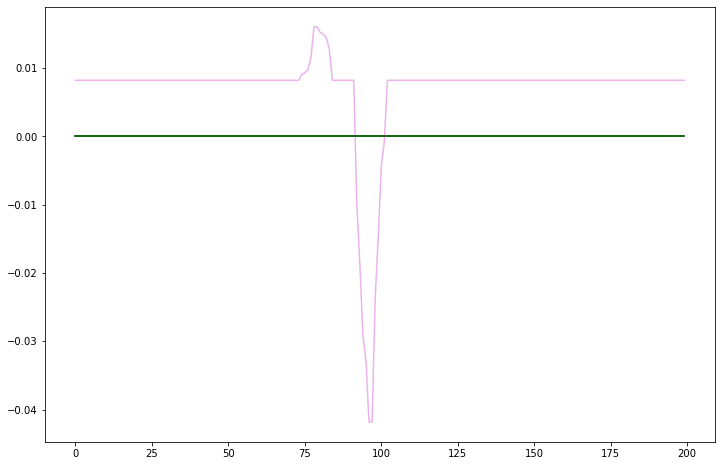

In [295]:
for idx in range(100):
    plt.figure(figsize=(12, 8))   
    plt.plot(y_test_scaled[idx], color = 'black')
    plt.plot(np.round(predictions[idx], 1), color = 'g', alpha = 0.9)
    plt.plot(predictions[idx], color = 'm', alpha = 0.3)
    plt.show()